In [1]:
import json
from datetime import datetime

import joblib
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
)

# Linear models
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

# Naive Bayes

# KNN
from sklearn.preprocessing import label_binarize

# SVM models
from sklearn.svm import SVC

# Tree-based models
from utils import EmotionDataPreprocessor, load_fer2013_data, augment_images

In [2]:
# 1. Load data (train split into train/val, and test)
print("Loading data...")
# Load original training data
X_train_full, y_train_full, emotion_labels = load_fer2013_data('Data_origin/train')
# Load test data
X_test, y_test, _ = load_fer2013_data('Data_origin/test')

Loading data...
Loading and preprocessing images...
Processing angry: 3995 images


Loading angry: 100%|██████████| 3995/3995 [00:35<00:00, 113.21it/s]



Processing disgust: 436 images


Loading disgust: 100%|██████████| 436/436 [00:02<00:00, 164.98it/s]


Processing fear: 4097 images


Loading fear: 100%|██████████| 4097/4097 [00:32<00:00, 126.24it/s]



Processing happy: 7215 images


Loading happy: 100%|██████████| 7215/7215 [00:49<00:00, 146.00it/s]



Processing sad: 4830 images


Loading sad: 100%|██████████| 4830/4830 [00:31<00:00, 151.39it/s]


Processing surprise: 3171 images


Loading surprise: 100%|██████████| 3171/3171 [00:19<00:00, 166.38it/s]


Processing neutral: 4965 images


Loading neutral: 100%|██████████| 4965/4965 [00:30<00:00, 161.94it/s]



Loading and preprocessing images...
Processing angry: 958 images


Loading angry: 100%|██████████| 958/958 [00:05<00:00, 163.86it/s]


Processing disgust: 111 images


Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 154.74it/s]


Processing fear: 1024 images


Loading fear: 100%|██████████| 1024/1024 [00:06<00:00, 165.04it/s]


Processing happy: 1774 images


Loading happy: 100%|██████████| 1774/1774 [00:11<00:00, 159.82it/s]


Processing sad: 1247 images


Loading sad: 100%|██████████| 1247/1247 [00:07<00:00, 165.49it/s]


Processing surprise: 831 images


Loading surprise: 100%|██████████| 831/831 [00:05<00:00, 162.75it/s]


Processing neutral: 1233 images


Loading neutral: 100%|██████████| 1233/1233 [00:07<00:00, 161.29it/s]



In [ ]:

# Augment DISGUST class (class 1)
X_train_full_augmented, y_train_full_augmented = augment_images(
    X_train_full, 
    y_train_full, 
    target_class=1,  # disgust
    target_count=2000, 
    emotion_labels=emotion_labels
)

# Split train into train and validation after augmented data (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_augmented, y_train_full_augmented, 
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=y_train_full_augmented  # Maintain class distribution
)

print("Data loaded and split successfully!")
print(f"   Original train samples: {len(X_train_full)}")
print(f"   New train samples: {len(X_train)} ({len(X_train)/len(X_train_full)*100:.1f}%)")
print(f"   Validation samples: {len(X_val)} ({len(X_val)/len(X_train_full)*100:.1f}%)")
print(f"   Test samples: {len(X_test)}")






print("\n NEW TRAINING SET DISTRIBUTION AFTER AUGMENTATION:")
unique_aug, counts_aug = np.unique(y_train, return_counts=True)
for idx, emotion in enumerate(emotion_labels):
    if idx in unique_aug:
        count = counts_aug[list(unique_aug).index(idx)]
        percentage = (count / len(y_train)) * 100
        change = ""
        if idx == 1:  # disgust
            old_count = np.sum(y_train == 1)
            change = f"   (+{count - old_count})"
        print(f"   {idx}. {emotion:10s}: {count:5d} samples ({percentage:5.2f}%){change}")

print(f"\n   TOTAL: {len(y_train)} samples (was {len(y_train)})")


 Augmenting class disgust (class 1)...
   Current samples: 436
   Target samples: 2000
   Need to generate: 1564 samples
   Generating 4 augmented versions per original image...


Augmenting disgust: 100%|██████████| 436/436 [00:00<00:00, 2748.18it/s]



    Augmentation completed!
   Total samples: 28709 → 30273
   disgust samples: 436 → 2000
Data loaded and split successfully!
   Original train samples: 28709
   New train samples: 24218 (84.4%)
   Validation samples: 6055 (21.1%)
   Test samples: 7178

 NEW TRAINING SET DISTRIBUTION AFTER AUGMENTATION:
   0. angry     :  3196 samples (13.20%)
   1. disgust   :  1600 samples ( 6.61%)   (+0)
   2. fear      :  3277 samples (13.53%)
   3. happy     :  5772 samples (23.83%)
   4. sad       :  3864 samples (15.96%)
   5. surprise  :  2537 samples (10.48%)
   6. neutral   :  3972 samples (16.40%)

   TOTAL: 24218 samples (was 24218)


In [ ]:
# ==============================================================================
# PREPROCESS AUGMENTED DATA
# ==============================================================================
print("\n" + "="*70)
print(" PREPROCESSING AUGMENTED TRAINING DATA")
print("="*70)

print(f"\n Augmented data info:")
print(f"   Data type: {X_train.dtype}")
print(f"   Shape: {X_train.shape}")
print(f"   Value range: [{X_train.min()}, {X_train.max()}]")
print(f"Emotion labels: {emotion_labels}")

# Create new preprocessor for augmented data
preprocessor_augmented = EmotionDataPreprocessor(
    target_size=(48, 48),
    random_state=42
)

# Fit transform on AUGMENTED training data
X_train_processed, train_info = preprocessor_augmented.fit_transform(
    X_train,
    pca_variance=0.65  
)

X_train_full_processed, train_full_info = preprocessor_augmented.transform(X_train_full_augmented)
X_val_processed, val_info = preprocessor_augmented.transform(X_val)
X_test_processed, test_info = preprocessor_augmented.transform(X_test)

print(f"\n Preprocessed augmented data:")
print(f"   Train shape: {X_train_processed.shape} (with {len(y_train)} labels)")
print(f"   Val shape: {X_val_processed.shape} (with {len(y_val)} labels)")


 PREPROCESSING AUGMENTED TRAINING DATA

 Augmented data info:
   Data type: float32
   Shape: (24218, 48, 48)
   Value range: [0.0, 23.0]
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

 TRAINING DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter:   0%|          | 0/24218 [00:00<?, ?it/s]

Median Filter: 100%|██████████| 24218/24218 [00:00<00:00, 139212.69it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 24218/24218 [00:01<00:00, 16659.40it/s]




[3/8] Resize and Normalize
  → Resizing to (48, 48) and Normalizing...


Resize: 100%|██████████| 24218/24218 [00:00<00:00, 331767.72it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...

  → Extracting HOG Features...


HOG: 100%|██████████| 24218/24218 [00:14<00:00, 1670.19it/s]



    HOG shape: (24218, 900)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/24218 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP:   0%|          | 52/24218 [00:00<00:47, 514.04it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 24218/24218 [00:53<00:00, 452.28it/s]



    LBP shape: (24218, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 24218/24218 [00:33<00:00, 732.66it/s]



    SIFT shape: (24218, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (24218, 2820)
    - HOG: 900 features
    - LBP: 640 features
    - SIFT: 1280 features
    - Total: 2820 features

[8/8] Standard Scaling and PCA
  → Fitting StandardScaler...
  → Combined shape: (24218, 2820)
    - HOG: 900 features
    - LBP: 640 features
    - SIFT: 1280 features
    - Total: 2820 features

[8/8] Standard Scaling and PCA
  → Fitting StandardScaler...
  → Fitting PCA (variance=0.65)...
  → Fitting PCA (variance=0.65)...
    PCA reduced: 2820 → 385 features
    Explained variance: 0.6501
    Number of components: 385

 TRAINING PREPROCESSING COMPLETED
Final shape: (24218, 385)
Original samples: 24218

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...
    PCA reduced: 2820 → 385 features
    Explained variance: 0.6501
    Number of components: 385

 TRAINING PREPROCESSING COMPLETED
Final shape: (24218, 385)
Original samples: 24218

 TEST DA

Median Filter: 100%|██████████| 30273/30273 [00:00<00:00, 142800.13it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 30273/30273 [00:01<00:00, 17742.76it/s]




[3/8] Resize and Normalize
  → Resizing to (48, 48) and Normalizing...


Resize: 100%|██████████| 30273/30273 [00:00<00:00, 365684.78it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 30273/30273 [00:17<00:00, 1687.02it/s]



    HOG shape: (30273, 900)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/30273 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP:   0%|          | 45/30273 [00:00<01:08, 442.68it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 30273/30273 [00:59<00:00, 508.82it/s]



    LBP shape: (30273, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 30273/30273 [00:38<00:00, 783.30it/s]



    SIFT shape: (30273, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (30273, 2820)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Combined shape: (30273, 2820)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...
  → Applying fitted PCA...

 TEST PREPROCESSING COMPLETED
Final shape: (30273, 385)
Original samples: 30273

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...

 TEST PREPROCESSING COMPLETED
Final shape: (30273, 385)
Original samples: 30273

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 6055/6055 [00:00<00:00, 50018.93it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 6055/6055 [00:00<00:00, 15216.17it/s]




[3/8] Resize and Normalize
  → Resizing to (48, 48) and Normalizing...


Resize: 100%|██████████| 6055/6055 [00:00<00:00, 243642.00it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 6055/6055 [00:04<00:00, 1390.98it/s]



    HOG shape: (6055, 900)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/6055 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 6055/6055 [00:11<00:00, 513.01it/s]


    LBP shape: (6055, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 6055/6055 [00:07<00:00, 760.80it/s]



    SIFT shape: (6055, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (6055, 2820)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

 TEST PREPROCESSING COMPLETED
Final shape: (6055, 385)
Original samples: 6055

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...

 TEST PREPROCESSING COMPLETED
Final shape: (6055, 385)
Original samples: 6055

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 7178/7178 [00:00<00:00, 30803.65it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 7178/7178 [00:00<00:00, 17416.90it/s]




[3/8] Resize and Normalize
  → Resizing to (48, 48) and Normalizing...


Resize: 100%|██████████| 7178/7178 [00:00<00:00, 364987.38it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 7178/7178 [00:04<00:00, 1620.83it/s]



    HOG shape: (7178, 900)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/7178 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP:   1%|          | 50/7178 [00:00<00:14, 496.26it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 7178/7178 [00:13<00:00, 515.36it/s]


    LBP shape: (7178, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 7178/7178 [00:09<00:00, 760.77it/s]



    SIFT shape: (7178, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (7178, 2820)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

 TEST PREPROCESSING COMPLETED
Final shape: (7178, 385)
Original samples: 7178

 Preprocessed augmented data:
   Train shape: (24218, 385) (with 24218 labels)
   Val shape: (6055, 385) (with 6055 labels)

 TEST PREPROCESSING COMPLETED
Final shape: (7178, 385)
Original samples: 7178

 Preprocessed augmented data:
   Train shape: (24218, 385) (with 24218 labels)
   Val shape: (6055, 385) (with 6055 labels)


# Logistic Regression 


STEP 1: BASELINE MODEL TRAINING

 Training baseline model...
   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.1s finished


Training completed!

 Training Set Performance:
   ROC-AUC (macro):     0.8146
   Accuracy:            0.4692
   F1-Score (macro):    0.4727
   F1-Score (weighted): 0.4612

 Validation Set Performance:
   ROC-AUC (macro):     0.7781
   Accuracy:            0.4388
   F1-Score (macro):    0.4460
   F1-Score (weighted): 0.4318

 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.2859    0.3066    0.2959       799
     disgust     0.7786    0.8350    0.8058       400
        fear     0.2986    0.2378    0.2648       820
       happy     0.5904    0.6244    0.6069      1443
         sad     0.3212    0.2640    0.2898       966
    surprise     0.4038    0.5726    0.4736       634
     neutral     0.4058    0.3666    0.3852       993

    accuracy                         0.4388      6055
   macro avg     0.4406    0.4581    0.4460      6055
weighted avg     0.4304    0.4388    0.4318      6055



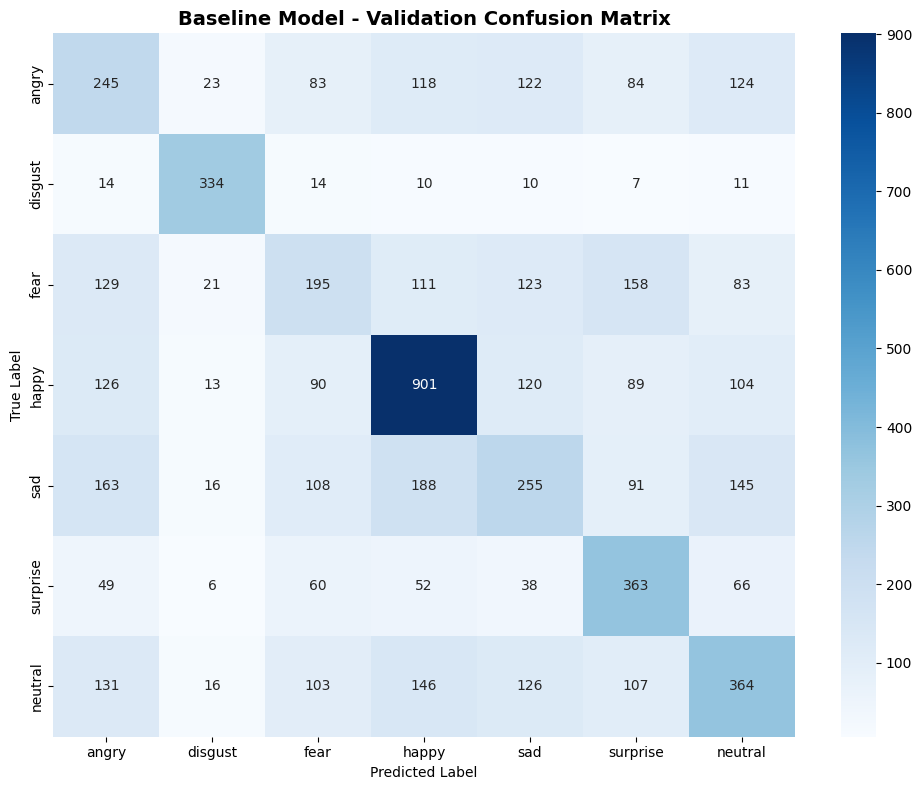


 BASELINE MODEL EVALUATION COMPLETED

 Baseline Performance Summary:
   Training ROC-AUC:   0.8146
   Validation ROC-AUC: 0.7781
   Difference:         0.0365


In [6]:
# STEP 1: Train baseline model with default parameters
print("\n" + "="*70)
print("STEP 1: BASELINE MODEL TRAINING")
print("="*70)


baseline_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    multi_class='ovr',
    n_jobs=-1,
    verbose=1
)

print("\n Training baseline model...")
print("   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced")

baseline_model.fit(X_train_processed, y_train)
print("Training completed!")

# Evaluate on training set
print("\n Training Set Performance:")
y_train_pred = baseline_model.predict(X_train_processed)
y_train_pred_proba = baseline_model.predict_proba(X_train_processed)

n_classes = len(emotion_labels)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
train_roc_auc = roc_auc_score(y_train_bin, y_train_pred_proba, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {train_roc_auc:.4f}")
print(f"   Accuracy:            {train_accuracy:.4f}")
print(f"   F1-Score (macro):    {train_f1_macro:.4f}")
print(f"   F1-Score (weighted): {train_f1_weighted:.4f}")

# Evaluate on validation set
print("\n Validation Set Performance:")
y_val_pred = baseline_model.predict(X_val_processed)
y_val_pred_proba = baseline_model.predict_proba(X_val_processed)

y_val_bin = label_binarize(y_val, classes=range(n_classes))

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
val_roc_auc = roc_auc_score(y_val_bin, y_val_pred_proba, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {val_roc_auc:.4f}")
print(f"   Accuracy:            {val_accuracy:.4f}")
print(f"   F1-Score (macro):    {val_f1_macro:.4f}")
print(f"   F1-Score (weighted): {val_f1_weighted:.4f}")

# Classification report
print("\n Validation Classification Report:")
report = classification_report(y_val, y_val_pred, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_val, y_val_pred, target_names=emotion_labels, digits=4))

# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Baseline Model - Validation Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix as artifact
cm_path = "baseline_confusion_matrix.png"
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

# Store baseline results
baseline_results = {
    'train': {
        'roc_auc': train_roc_auc,
        'accuracy': train_accuracy,
        'f1_macro': train_f1_macro,
        'f1_weighted': train_f1_weighted
    },
    'validation': {
        'roc_auc': val_roc_auc,
        'accuracy': val_accuracy,
        'f1_macro': val_f1_macro,
        'f1_weighted': val_f1_weighted
    }
}

# Log baseline results as JSON artifact
baseline_json = "baseline_results.json"
with open(baseline_json, 'w') as f:
    json.dump(baseline_results, f, indent=4)


print("\n" + "="*70)
print(" BASELINE MODEL EVALUATION COMPLETED")
print("="*70)
print("\n Baseline Performance Summary:")
print(f"   Training ROC-AUC:   {train_roc_auc:.4f}")
print(f"   Validation ROC-AUC: {val_roc_auc:.4f}")
print(f"   Difference:         {abs(train_roc_auc - val_roc_auc):.4f}")

# Log overfitting metric
overfitting_gap = train_roc_auc - val_roc_auc


if train_roc_auc - val_roc_auc > 0.05:
    print("     Warning: Possible overfitting detected!")
    

In [ ]:
# STEP 2: Hyperparameter Tuning with GridSearchCV (Demo - 10 combinations)
print("\n" + "="*70)
print(" STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*70)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1],  # ← THÊM 0.0001 (cực mạnh) và 0.01
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [1000],
    'class_weight': ['balanced']
}

print("\n Parameter Grid (Demo - Limited Combinations):")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver']) * len(param_grid['max_iter']) * len(param_grid['class_weight'])
print(f"\nTotal combinations to test: {total_combinations}")
print(f"Baseline ROC-AUC to beat: {val_roc_auc:.4f}\n")

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, multi_class='ovr', n_jobs=-1),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation on training data
    scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV
print(" Running GridSearchCV...")
grid_search.fit(X_train_processed, y_train)
print(" GridSearchCV completed!")
print(f"   Best CV ROC-AUC:      {grid_search.best_score_:.4f}")
# Get results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')



results_list = []
best_roc_auc = val_roc_auc
best_model = baseline_model
best_run_id = None
top_k = 3

for idx in range(top_k):
    row = cv_results.iloc[idx]
    
    # Extract parameters
    params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
    
    # Train model with these parameters on full training set
    model = LogisticRegression(**params, random_state=42, multi_class='ovr', n_jobs=-1)
    # model.fit(X_train_full_processed, y_train_full_augmented)
    model.fit(X_train_processed, y_train)
    
    y_train_pred = model.predict(X_train_processed)
    y_train_pred_proba = model.predict_proba(X_train_processed)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
    train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
    train_roc_auc = roc_auc_score(y_train_bin, y_train_pred_proba, average='macro', multi_class='ovr')
    
    print(f"   ROC-AUC (macro):     {train_roc_auc:.4f}")
    print(f"   Accuracy:            {train_accuracy:.4f}")
    print(f"   F1-Score (macro):    {train_f1_macro:.4f}")
    print(f"   F1-Score (weighted): {train_f1_weighted:.4f}")
    # Evaluate on validation set
    y_val_pred = model.predict(X_val_processed)
    y_val_pred_proba = model.predict_proba(X_val_processed)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val_bin, y_val_pred_proba, average='macro', multi_class='ovr')
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    print(f"   ROC-AUC (macro):     {roc_auc:.4f}")
    print(f"   Accuracy:            {accuracy:.4f}")
    print(f"   F1-Score (macro):    {f1_macro:.4f}")
    print(f"   F1-Score (weighted): {f1_weighted:.4f}")
    
    
    
    # Store results
    result = {
        
        **params,
        'cv_mean_score': row['mean_test_score'],
        'cv_std_score': row['std_test_score'],
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    results_list.append(result)
    
    # Update best model
    if roc_auc > best_roc_auc:
        improvement = roc_auc - best_roc_auc
        best_roc_auc = roc_auc
        best_model = model
        
        best_params = params
        best_metrics = {
            'val_roc_auc': roc_auc,
            'val_accuracy': accuracy,
            'val_f1_macro': f1_macro,
            'val_f1_weighted': f1_weighted
        }
        
        print(f" New best model found! (+{improvement:.4f})")
        print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
        print(f"   CV Score: {row['mean_test_score']:.4f}")
        print(f"   Params: {params}")
        
# Save CV results
cv_results_path = "gridsearch_cv_results.csv"
cv_results.to_csv(cv_results_path, index=False)

print("\n" + "="*70)
print(" GRIDSEARCHCV HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement = best_roc_auc - baseline_results['validation']['roc_auc']
print("\n Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {grid_search.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc:.4f}")
print(f"   Improvement:          {improvement:.4f} ({improvement/baseline_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Total combinations:   {total_combinations}")



 STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV

 Parameter Grid (Demo - Limited Combinations):
   C: [0.001, 0.01, 0.1]
   penalty: ['l2']
   solver: ['lbfgs']
   max_iter: [1000]
   class_weight: ['balanced']

Total combinations to test: 3
Baseline ROC-AUC to beat: 0.7781

 Running GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


 GridSearchCV completed!
   Best CV ROC-AUC:      0.7756


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


   ROC-AUC (macro):     0.8144
   Accuracy:            0.4717
   F1-Score (macro):    0.4798
   F1-Score (weighted): 0.4654
   ROC-AUC (macro):     0.7792
   Accuracy:            0.4411
   F1-Score (macro):    0.4539
   F1-Score (weighted): 0.4363
 New best model found! (+0.0011)
   ROC-AUC: 0.7792 | Accuracy: 0.4411 | F1-Macro: 0.4539
   CV Score: 0.7756
   Params: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


   ROC-AUC (macro):     0.8146
   Accuracy:            0.4695
   F1-Score (macro):    0.4736
   F1-Score (weighted): 0.4616
   ROC-AUC (macro):     0.7782
   Accuracy:            0.4393
   F1-Score (macro):    0.4475
   F1-Score (weighted): 0.4326


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


   ROC-AUC (macro):     0.8146
   Accuracy:            0.4694
   F1-Score (macro):    0.4729
   F1-Score (weighted): 0.4613
   ROC-AUC (macro):     0.7781
   Accuracy:            0.4386
   F1-Score (macro):    0.4460
   F1-Score (weighted): 0.4316

 GRIDSEARCHCV HYPERPARAMETER TUNING COMPLETED

 Tuning Results:
   Baseline ROC-AUC:     0.7781
   Best CV ROC-AUC:      0.7756
   Best Val ROC-AUC:     0.7792
   Improvement:          0.0011 (0.14%)
   Total combinations:   3


#check lại các biến khi sau khi tuning


 TOP 10 MODELS BY ROC-AUC:
    C class_weight  max_iter penalty solver  cv_mean_score  cv_std_score  roc_auc  accuracy  f1_macro  f1_weighted
0.001     balanced      1000      l2  lbfgs       0.775583      0.002005 0.779166  0.441123  0.453899     0.436349
0.010     balanced      1000      l2  lbfgs       0.773368      0.002001 0.778248  0.439306  0.447517     0.432597
0.100     balanced      1000      l2  lbfgs       0.772983      0.001987 0.778122  0.438646  0.446049     0.431638


C:\Users\nguye\AppData\Local\Temp\ipykernel_22220\1712336227.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(penalty_comparison.values(), labels=penalty_comparison.keys())
C:\Users\nguye\AppData\Local\Temp\ipykernel_22220\1712336227.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(solver_comparison.values(), labels=solver_comparison.keys())


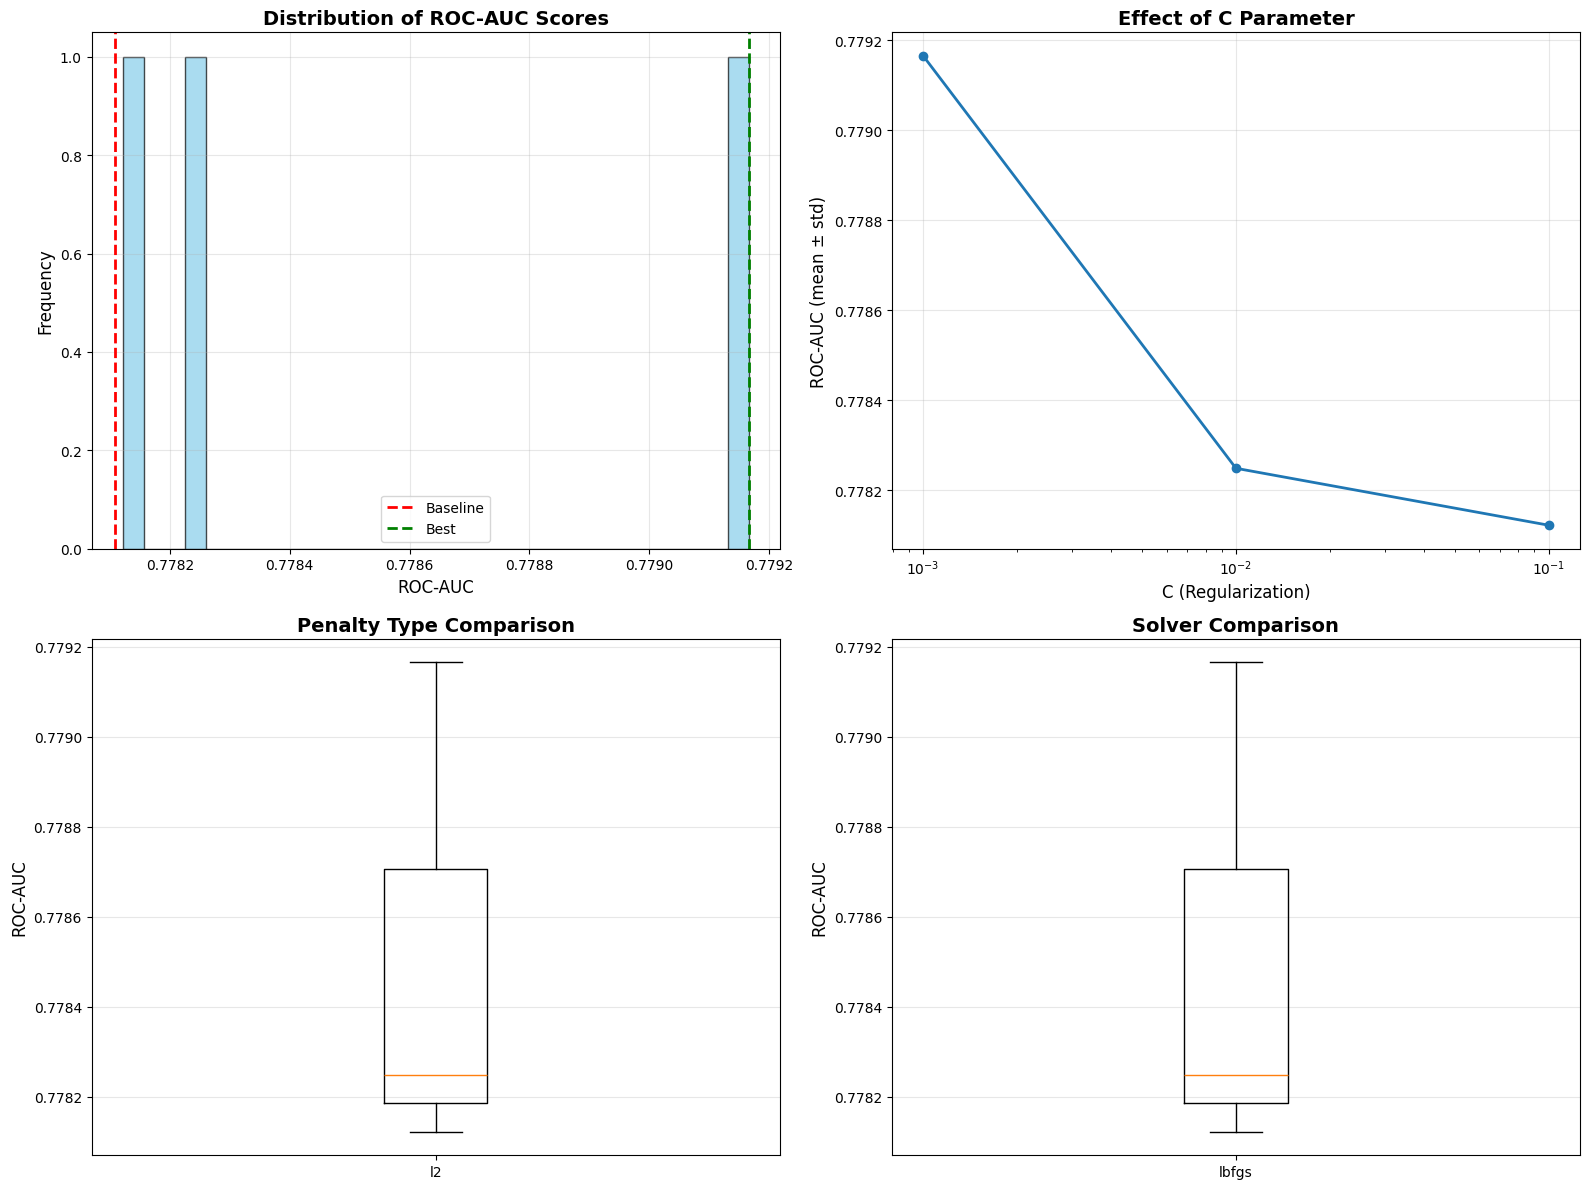


 BEST MODEL PARAMETERS

Best Parameters:
  C: 0.001
  class_weight: balanced
  max_iter: 1000
  penalty: l2
  solver: lbfgs

Validation Metrics:
  val_roc_auc: 0.7792
  val_accuracy: 0.4411
  val_f1_macro: 0.4539
  val_f1_weighted: 0.4363


In [ ]:
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('roc_auc', ascending=False)

print("\n TOP 10 MODELS BY ROC-AUC:")
print(results_df.head(10).to_string(index=False))

# Save results to CSV and log as artifact
results_csv = "tuning_results.csv"
results_df.to_csv(results_csv, index=False)


# Visualize tuning results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC-AUC distribution
ax1 = axes[0, 0]
ax1.hist(results_df['roc_auc'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(baseline_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.axvline(best_roc_auc, color='green', linestyle='--', linewidth=2, label='Best')
ax1.set_xlabel('ROC-AUC', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of ROC-AUC Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. C parameter effect
ax2 = axes[0, 1]
c_effect = results_df.groupby('C')['roc_auc'].agg(['mean', 'std']).reset_index()
ax2.errorbar(c_effect['C'], c_effect['mean'], yerr=c_effect['std'], marker='o', capsize=5, capthick=2, linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('C (Regularization)', fontsize=12)
ax2.set_ylabel('ROC-AUC (mean ± std)', fontsize=12)
ax2.set_title('Effect of C Parameter', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Penalty comparison
ax3 = axes[1, 0]
penalty_comparison = results_df.groupby('penalty')['roc_auc'].apply(list).to_dict()
ax3.boxplot(penalty_comparison.values(), labels=penalty_comparison.keys())
ax3.set_ylabel('ROC-AUC', fontsize=12)
ax3.set_title('Penalty Type Comparison', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# 4. Solver comparison
ax4 = axes[1, 1]
solver_comparison = results_df.groupby('solver')['roc_auc'].apply(list).to_dict()
ax4.boxplot(solver_comparison.values(), labels=solver_comparison.keys())
ax4.set_ylabel('ROC-AUC', fontsize=12)
ax4.set_title('Solver Comparison', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

plt.tight_layout()

# Log visualization as artifact
tuning_viz_path = 'hyperparameter_tuning_analysis.png'
plt.savefig(tuning_viz_path, dpi=300, bbox_inches='tight')

plt.show()

print("\n" + "="*70)
print(" BEST MODEL PARAMETERS")
print("="*70)
print("\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print("\nValidation Metrics:")
for key, value in best_metrics.items():
    print(f"  {key}: {value:.4f}")




 FINAL EVALUATION ON TEST SET

Test Set Metrics:
  ROC-AUC (macro):     0.7516
  Accuracy:            0.4122
  F1-Score (macro):    0.3564
  F1-Score (weighted): 0.4044

 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.2878    0.3121    0.2994       958
     disgust     0.1569    0.1441    0.1502       111
        fear     0.2802    0.2285    0.2517      1024
       happy     0.5949    0.6381    0.6157      1774
         sad     0.2974    0.2390    0.2650      1247
    surprise     0.4518    0.5921    0.5125       831
     neutral     0.4040    0.3958    0.3998      1233

    accuracy                         0.4122      7178
   macro avg     0.3533    0.3642    0.3564      7178
weighted avg     0.4012    0.4122    0.4044      7178



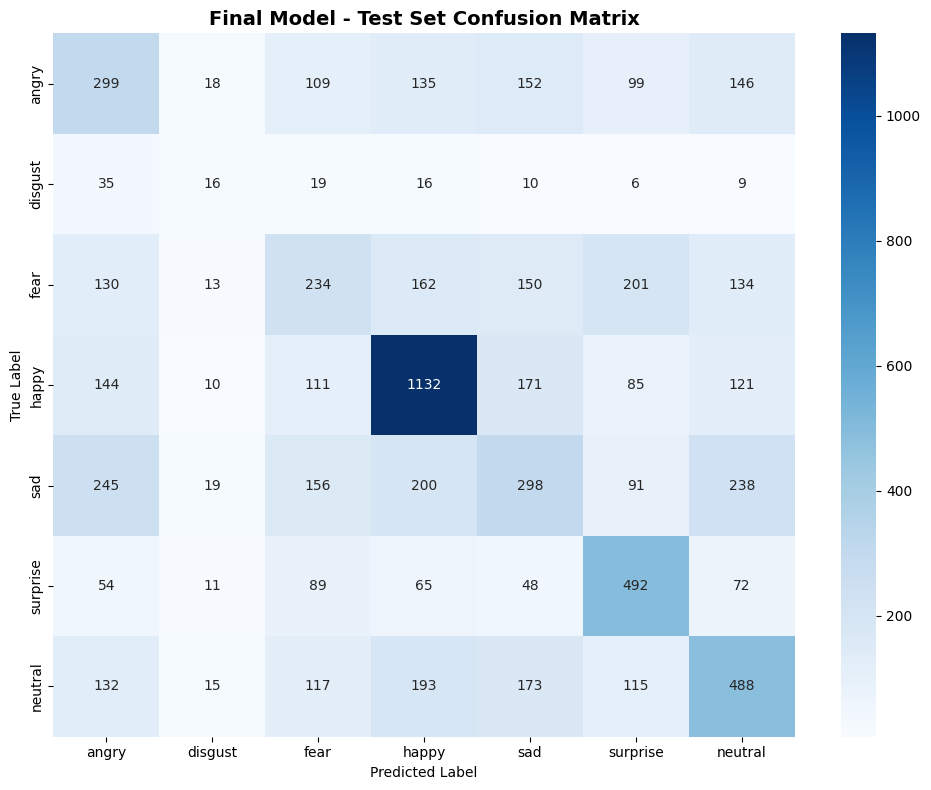

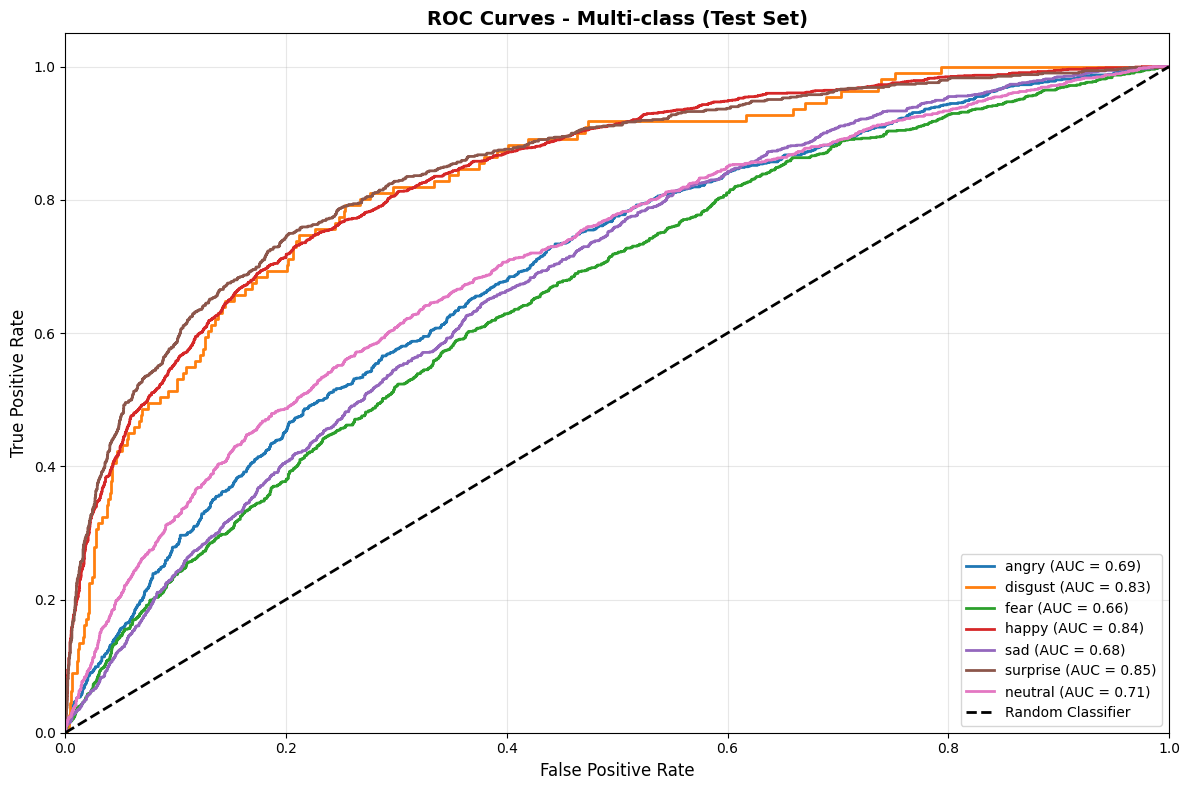


 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.287777 0.312109  0.299449      958
 disgust   0.156863 0.144144  0.150235      111
    fear   0.280240 0.228516  0.251748     1024
   happy   0.594850 0.638106  0.615719     1774
     sad   0.297405 0.238974  0.265007     1247
surprise   0.451791 0.592058  0.512500      831
 neutral   0.403974 0.395783  0.399836     1233

 Model saved: models/logistic_regression_best_20251123_035756.pkl
 Results saved: models/logistic_regression_results_20251123_035756.json

 TRAINING PIPELINE COMPLETED SUCCESSFULLY

 Final Test Performance:
  ROC-AUC:  0.7516
  Accuracy: 0.4122
  F1-Score: 0.3564
 Model saved as: models/logistic_regression_best_20251123_035756.pkl


In [ ]:

print("\n" + "="*70)
print(" FINAL EVALUATION ON TEST SET")
print("="*70)

# Predict on test set
y_test_pred = best_model.predict(X_test_processed)
y_test_pred_proba = best_model.predict_proba(X_test_processed)

y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Calculate all metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test_bin, y_test_pred_proba, average='macro', multi_class='ovr')

print("\nTest Set Metrics:")
print(f"  ROC-AUC (macro):     {test_roc_auc:.4f}")
print(f"  Accuracy:            {test_accuracy:.4f}")
print(f"  F1-Score (macro):    {test_f1_macro:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted:.4f}")

# Classification report
print("\n Test Classification Report:")
report = classification_report(y_test, y_test_pred, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_test, y_test_pred, target_names=emotion_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix
test_cm_path = 'test_confusion_matrix.png'
plt.savefig(test_cm_path, dpi=300, bbox_inches='tight')

plt.show()

# ROC Curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
    
  

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Log ROC curves
roc_path = 'test_roc_curves.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')

plt.show()

# Per-class metrics table
print("\n Per-Class Metrics:")
class_metrics = []
for i, emotion in enumerate(emotion_labels):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics.append({
        'Emotion': emotion,
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'Support': int(cm[i, :].sum())
    })

class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df.to_string(index=False))

# Save and log class metrics
class_metrics_csv = "test_class_metrics.csv"
class_metrics_df.to_csv(class_metrics_csv, index=False)


# Save final model 
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'models/logistic_regression_best_{timestamp}.pkl'

joblib.dump(best_model, model_filename)
print(f"\n Model saved: {model_filename}")




# Save complete results
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

final_results = {
    'model_name': 'Logistic Regression',
    'timestamp': timestamp,
    'best_params': convert_to_native_types(best_params),
    
    'validation_metrics': convert_to_native_types(best_metrics),
    'test_metrics': {
        'roc_auc': float(test_roc_auc),
        'accuracy': float(test_accuracy),
        'f1_macro': float(test_f1_macro),
        'f1_weighted': float(test_f1_weighted)
    },
    'per_class_metrics': class_metrics,
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'feature_dimension': int(X_train_processed.shape[1]),
    'emotion_labels': emotion_labels
}

results_filename = f'models/logistic_regression_results_{timestamp}.json'
with open(results_filename, 'w') as f:
    json.dump(final_results, f, indent=4)
print(f" Results saved: {results_filename}")



print("\n" + "="*70)
print(" TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print("\n Final Test Performance:")
print(f"  ROC-AUC:  {test_roc_auc:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score: {test_f1_macro:.4f}")

print(f" Model saved as: {model_filename}")


# Random forest


 STEP 1: BASELINE RANDOM FOREST MODEL TRAINING

 Training baseline Random Forest...
   Parameters: n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


 Training completed!

 Training Set Performance:


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.3s finished


   ROC-AUC (macro):     0.9996
   Accuracy:            0.9985
   F1-Score (macro):    0.9981
   F1-Score (weighted): 0.9985

 Validation Set Performance:


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished


   ROC-AUC (macro):     0.7683
   Accuracy:            0.3891
   F1-Score (macro):    0.3639
   F1-Score (weighted): 0.3308

 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.6897    0.0751    0.1354       799
     disgust     0.9882    0.8375    0.9066       400
        fear     0.6857    0.0878    0.1557       820
       happy     0.3139    0.9501    0.4719      1443
         sad     0.3486    0.1418    0.2016       966
    surprise     0.9576    0.2492    0.3955       634
     neutral     0.3723    0.2246    0.2802       993

    accuracy                         0.3891      6055
   macro avg     0.6223    0.3666    0.3639      6055
weighted avg     0.5409    0.3891    0.3308      6055



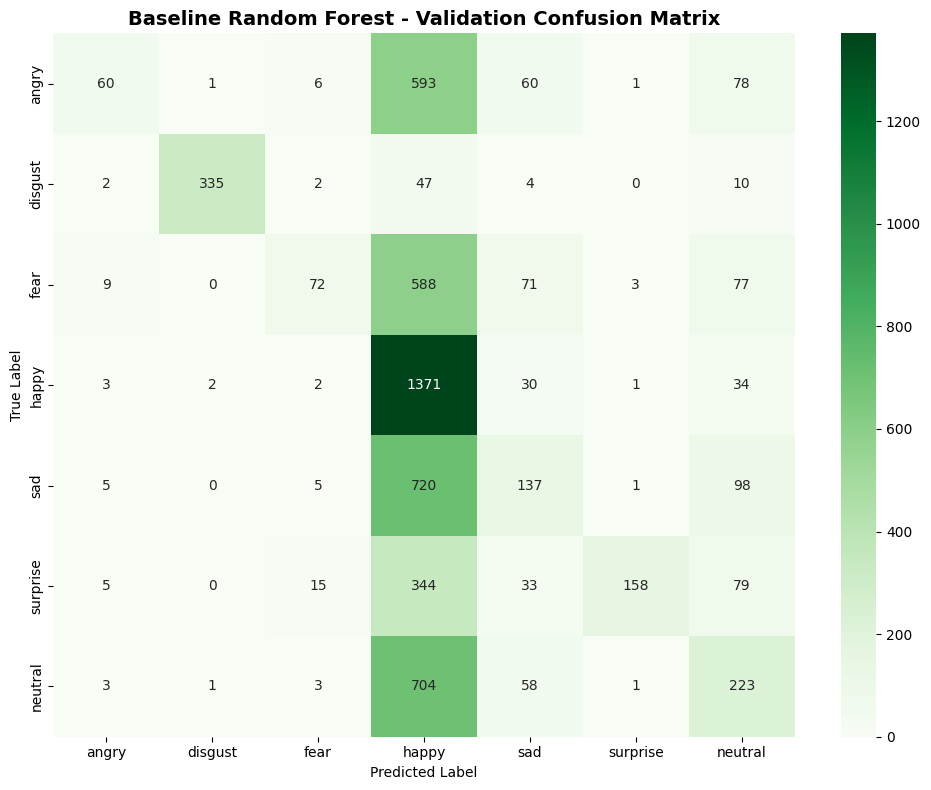

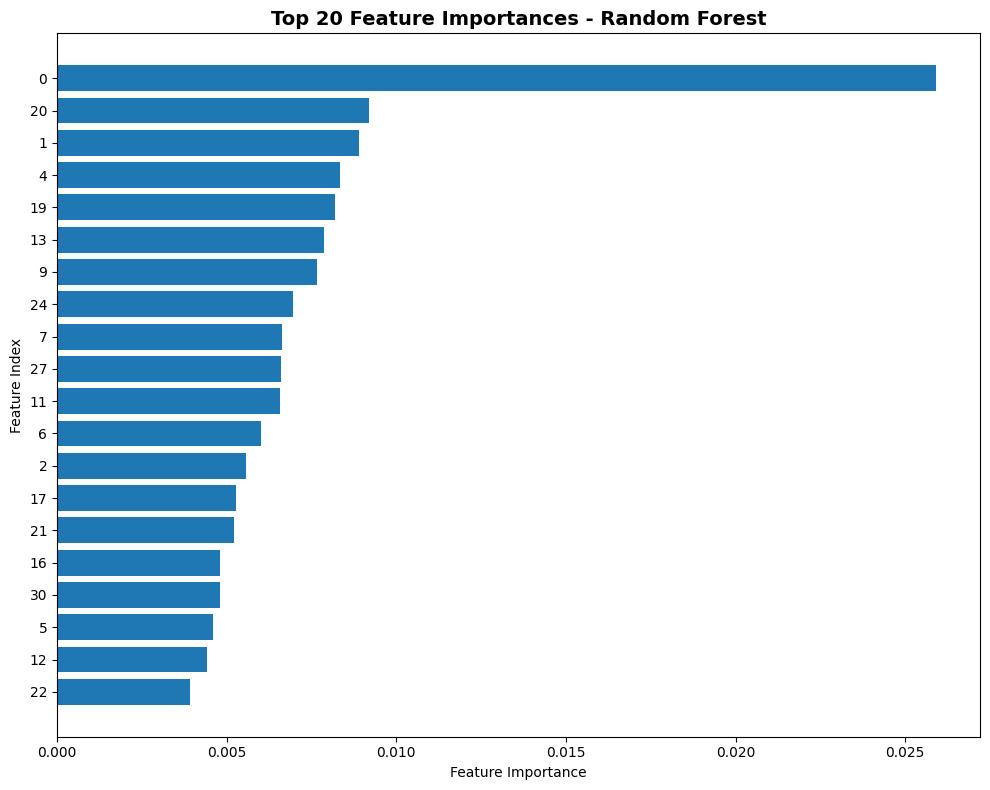


 BASELINE RANDOM FOREST MODEL EVALUATION COMPLETED

 Baseline Performance Summary:
   Training ROC-AUC:   0.9996
   Validation ROC-AUC: 0.7683
   Difference:         0.2312


In [ ]:
# STEP 1: Train baseline Random Forest model
print("\n" + "="*70)
print(" STEP 1: BASELINE RANDOM FOREST MODEL TRAINING")
print("="*70)


baseline_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,  
    min_samples_leaf=2,
    max_features="sqrt",   
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n Training baseline Random Forest...")
print("   Parameters: n_estimators=300, max_depth=20, min_samples_split=5, "
        "min_samples_leaf=2, max_features=sqrt")

baseline_rf.fit(X_train_processed, y_train)
print(" Training completed!")

# -------- Chuẩn bị cho ROC-AUC đa lớp --------
n_classes_rf   = len(emotion_labels)
y_train_bin_rf = label_binarize(y_train, classes=range(n_classes_rf))
y_val_bin_rf   = label_binarize(y_val,   classes=range(n_classes_rf))

# ===================== TRAIN METRICS =====================
print("\n Training Set Performance:")
y_train_pred_rf       = baseline_rf.predict(X_train_processed)
y_train_pred_proba_rf = baseline_rf.predict_proba(X_train_processed)

train_accuracy_rf     = accuracy_score(y_train, y_train_pred_rf)
train_f1_macro_rf     = f1_score(y_train, y_train_pred_rf, average='macro')
train_f1_weighted_rf  = f1_score(y_train, y_train_pred_rf, average='weighted')
train_roc_auc_rf      = roc_auc_score(
    y_train_bin_rf, y_train_pred_proba_rf, average='macro', multi_class='ovr'
)

print(f"   ROC-AUC (macro):     {train_roc_auc_rf:.4f}")
print(f"   Accuracy:            {train_accuracy_rf:.4f}")
print(f"   F1-Score (macro):    {train_f1_macro_rf:.4f}")
print(f"   F1-Score (weighted): {train_f1_weighted_rf:.4f}")


# ===================== VAL METRICS =====================
print("\n Validation Set Performance:")
y_val_pred_rf       = baseline_rf.predict(X_val_processed)
y_val_pred_proba_rf = baseline_rf.predict_proba(X_val_processed)

val_accuracy_rf     = accuracy_score(y_val, y_val_pred_rf)
val_f1_macro_rf     = f1_score(y_val, y_val_pred_rf, average='macro')
val_f1_weighted_rf  = f1_score(y_val, y_val_pred_rf, average='weighted')
val_roc_auc_rf      = roc_auc_score(
    y_val_bin_rf, y_val_pred_proba_rf, average='macro', multi_class='ovr'
)

print(f"   ROC-AUC (macro):     {val_roc_auc_rf:.4f}")
print(f"   Accuracy:            {val_accuracy_rf:.4f}")
print(f"   F1-Score (macro):    {val_f1_macro_rf:.4f}")
print(f"   F1-Score (weighted): {val_f1_weighted_rf:.4f}")



# ===================== REPORT & CONFUSION MATRIX =====================
print("\n Validation Classification Report:")
report_rf = classification_report(
    y_val, y_val_pred_rf, target_names=emotion_labels, digits=4, output_dict=True
)
print(classification_report(y_val, y_val_pred_rf, target_names=emotion_labels, digits=4))

# Confusion matrix
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Baseline Random Forest - Validation Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
cm_path_rf = "baseline_rf_confusion_matrix.png"
plt.savefig(cm_path_rf, dpi=300, bbox_inches='tight')

plt.show()

fi = baseline_rf.feature_importances_
top_n = min(20, fi.shape[0])
top_idx = np.argsort(fi)[-top_n:]
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), fi[top_idx])
plt.yticks(range(top_n), top_idx)
plt.xlabel('Feature Importance') 
plt.ylabel('Feature Index')
plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
fi_path = "baseline_rf_feature_importance.png"
plt.savefig(fi_path, dpi=300, bbox_inches='tight')

plt.show()


baseline_rf_results = {
    "train": {
        "roc_auc": float(train_roc_auc_rf),
        "accuracy": float(train_accuracy_rf),
        "f1_macro": float(train_f1_macro_rf),
        "f1_weighted": float(train_f1_weighted_rf)
    },
    "validation": {
        "roc_auc": float(val_roc_auc_rf),
        "accuracy": float(val_accuracy_rf),
        "f1_macro": float(val_f1_macro_rf),
        "f1_weighted": float(val_f1_weighted_rf)
    }
}
baseline_rf_json = "baseline_rf_results.json"
with open(baseline_rf_json, "w") as f:
    json.dump(baseline_rf_results, f, indent=4)


print("\n" + "="*70)
print(" BASELINE RANDOM FOREST MODEL EVALUATION COMPLETED")
print("="*70)
print("\n Baseline Performance Summary:")
print(f"   Training ROC-AUC:   {train_roc_auc_rf:.4f}")
print(f"   Validation ROC-AUC: {val_roc_auc_rf:.4f}")
print(f"   Difference:         {abs(train_roc_auc_rf - val_roc_auc_rf):.4f}")

# Overfitting gap
overfitting_gap_rf = float(train_roc_auc_rf - val_roc_auc_rf)

if overfitting_gap_rf > 0.05:
    print("     Warning: Possible overfitting detected!")
    




In [ ]:
# STEP 2: Hyperparameter Tuning for Random Forest using RandomizedSearchCV
print("\n" + "="*70)
print(" STEP 2: HYPERPARAMETER TUNING FOR RANDOM FOREST (Anti-Overfit)")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

# Stronger regularization to prevent overfit
param_distributions_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 6, 7, 8],  # Shallower trees
    'min_samples_split': [30, 40, 50, 60],  # Higher split requirements
    'min_samples_leaf': [15, 20, 25, 30],  # Larger leaf sizes
    'max_features': ['sqrt', 'log2']
}

print("\n Parameter Distributions (Demo - Limited for faster execution):")
for param, dist in param_distributions_rf.items():
    print(f"   {param}: {dist}")

n_iter = 25  # More iterations to find good combination
print(f"\nRandomized Search iterations: {n_iter}")
print(f"Baseline ROC-AUC to beat: {val_roc_auc_rf:.4f}")
print(f"Overfit constraint: Train-Val gap must be < 12%\n")

# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions_rf,
    n_iter=n_iter,
    cv=3,  # 3-fold cross-validation on training data
    scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV
print(" Running RandomizedSearchCV with AUGMENTED data (should complete in a few minutes)...")
rf_random.fit(X_train_processed, y_train)
print(" RandomizedSearchCV completed!")

# Get results
cv_results = pd.DataFrame(rf_random.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

# Initialize tracking - prioritize HIGHEST Val ROC-AUC among non-overfit models
results_list_rf = []
best_roc_auc_rf = 0.0
best_overfit_gap = 1.0
best_rf_model = None
best_run_id_rf = None
best_params_rf = {}
best_metrics_rf = {}

# Save baseline for final comparison
baseline_val_saved = val_roc_auc_rf
baseline_model_saved = baseline_rf

print("="*70)
print("Evaluating models with overfit gap check...")
print("="*70 + "\n")

# Evaluate each model
for idx in range(len(cv_results)):
    row = cv_results.iloc[idx]
    params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
    
    print(f"Model {idx+1}/{len(cv_results)}:")
    print(f"   Params: {params}")
    
    # Get the model from CV
    model_idx = row['rank_test_score'] - 1
    model_rf = rf_random.cv_results_['params'][model_idx]
    fitted_model = RandomForestClassifier(**model_rf, random_state=42, n_jobs=-1)
    fitted_model.fit(X_train_processed, y_train)
    
    # Evaluate on validation set
    y_val_pred = fitted_model.predict(X_val_processed)
    y_val_pred_proba = fitted_model.predict_proba(X_val_processed)
    
    roc_auc = roc_auc_score(y_val_bin_rf, y_val_pred_proba, average='macro', multi_class='ovr')
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    
    print(f"   Val: ROC-AUC {roc_auc:.4f} | Acc {accuracy:.4f} | F1-Macro {f1_macro:.4f}")
    
    # Training metrics
    y_train_pred_rf = fitted_model.predict(X_train_processed)
    y_train_pred_proba_rf = fitted_model.predict_proba(X_train_processed)
    
    train_roc_auc_rf = roc_auc_score(y_train_bin_rf, y_train_pred_proba_rf, average='macro', multi_class='ovr')
    train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
    train_f1_macro_rf = f1_score(y_train, y_train_pred_rf, average='macro')
    
    print(f"   Train: ROC-AUC {train_roc_auc_rf:.4f} | Acc {train_accuracy_rf:.4f} | F1-Macro {train_f1_macro_rf:.4f}")
    
    # Calculate overfit gap
    overfit_gap = abs(train_roc_auc_rf - roc_auc)
    
    # Assess gap
    print(f"   → Gap: {overfit_gap*100:.2f}% | ", end="")
    if overfit_gap < 0.10:
        print(" EXCELLENT (< 10%)")
    elif overfit_gap < 0.12:
        print(" ACCEPTABLE (< 12%)")
    else:
        print(f" OVERFIT (>= 12%)")
    
    # Store results
    result = {
        **params,
        'cv_mean_score': row['mean_test_score'],
        'val_roc_auc': roc_auc,
        'val_accuracy': accuracy,
        'val_f1_macro': f1_macro,
        'val_f1_weighted': f1_weighted,
        'train_roc_auc': train_roc_auc_rf,
        'overfit_gap': overfit_gap
    }
    results_list_rf.append(result)
    
    # Update best model - PRIORITIZE HIGHEST VAL ROC-AUC among non-overfit models
    # Strategy: Among models with gap < 12%, choose the one with HIGHEST val ROC-AUC
    if overfit_gap < 0.12:  # Passes overfit constraint
        if roc_auc > best_roc_auc_rf:
            # Better val score among models passing constraint
            best_roc_auc_rf = roc_auc
            best_overfit_gap = overfit_gap
            best_rf_model = fitted_model
            best_params_rf = params
            best_metrics_rf = {
                'val_roc_auc': roc_auc,
                'val_accuracy': accuracy,
                'val_f1_macro': f1_macro,
                'val_f1_weighted': f1_weighted
            }
            print(f" NEW BEST! Val ROC-AUC: {roc_auc:.4f}, Gap: {overfit_gap*100:.2f}%")
    
    print()

# Save CV results
cv_results_path = "rf_cv_results.csv"
cv_results.to_csv(cv_results_path, index=False)

print("\n" + "="*70)
print(" RANDOMIZED HYPERPARAMETER TUNING COMPLETED")
print("="*70)

# Calculate baseline gap
baseline_gap = abs(baseline_rf_results['train']['roc_auc'] - baseline_rf_results['validation']['roc_auc'])

print("\n Final Comparison:")
print(f"\n   BASELINE MODEL:")
print(f"      Val ROC-AUC: {baseline_val_saved:.4f}")
print(f"      Train ROC-AUC: {baseline_rf_results['train']['roc_auc']:.4f}")
print(f"      Overfit Gap: {baseline_gap*100:.2f}%")
if baseline_gap >= 0.12:
    print(f"      Status:  OVERFITTING")
else:
    print(f"      Status:  OK")

# Check if we found a better model
if best_rf_model is not None:
    print(f"\n   BEST TUNED MODEL:")
    print(f"      Val ROC-AUC: {best_roc_auc_rf:.4f}")
    # Get train score
    y_best_train_pred = best_rf_model.predict_proba(X_train_processed)
    best_train_score = roc_auc_score(y_train_bin_rf, y_best_train_pred, average='macro', multi_class='ovr')
    best_gap = abs(best_train_score - best_roc_auc_rf)
    print(f"      Train ROC-AUC: {best_train_score:.4f}")
    print(f"      Overfit Gap: {best_gap*100:.2f}%")
    print(f"      Status:  NO OVERFIT")
    print(f"      Parameters: {best_params_rf}")
    
    improvement_rf = best_roc_auc_rf - baseline_val_saved
    print(f"\n DECISION: Use TUNED model")
    print(f"   Val change: {improvement_rf:.4f} ({improvement_rf/baseline_val_saved*100:.2f}%)")
    print(f"   Gap improvement: {baseline_gap*100:.2f}% → {best_gap*100:.2f}%")
    print(f"   Reason: Eliminated overfit - more reliable for test set")
else:
    print(f"\n DECISION: Keep BASELINE model")
    print(f"   Reason: No tuned model passed overfit constraint (<12% gap)")
    # Restore baseline
    best_rf_model = baseline_model_saved
    best_roc_auc_rf = baseline_val_saved
    best_params_rf = {}
    best_metrics_rf = {
        'val_roc_auc': baseline_val_saved,
        'val_accuracy': val_accuracy_rf,
        'val_f1_macro': val_f1_macro_rf,
        'val_f1_weighted': val_f1_weighted_rf
    }
    improvement_rf = 0


 STEP 2: HYPERPARAMETER TUNING FOR RANDOM FOREST (Anti-Overfit)

 Parameter Distributions (Demo - Limited for faster execution):
   n_estimators: [50, 100, 150]
   max_depth: [5, 6, 7, 8]
   min_samples_split: [30, 40, 50, 60]
   min_samples_leaf: [15, 20, 25, 30]
   max_features: ['sqrt', 'log2']

Randomized Search iterations: 25
Baseline ROC-AUC to beat: 0.7683
Overfit constraint: Train-Val gap must be < 12%

 Running RandomizedSearchCV with AUGMENTED data (should complete in a few minutes)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
 RandomizedSearchCV completed!
Evaluating models with overfit gap check...

Model 1/25:
   Params: {'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 8}
 RandomizedSearchCV completed!
Evaluating models with overfit gap check...

Model 1/25:
   Params: {'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 8}
   Val: ROC-AUC 0


 TOP 10 RANDOM FOREST MODELS BY VALIDATION ROC-AUC:
 cv_mean_score  val_roc_auc  train_roc_auc  overfit_gap  val_accuracy  val_f1_macro  n_estimators  max_depth  min_samples_split  min_samples_leaf
      0.743188     0.756095       0.905859     0.149764      0.312139      0.221745           150          7                 40                15
      0.733673     0.748872       0.909665     0.160793      0.287696      0.179258           100          7                 60                15
      0.733825     0.747741       0.861714     0.113974      0.303881      0.206360           100          7                 50                15
      0.730436     0.745827       0.833257     0.087430      0.297275      0.195406            50          6                 50                20
      0.726246     0.744402       0.864027     0.119625      0.288026      0.179669            50          5                 40                30
      0.726246     0.744402       0.864027     0.119625      0.288026  

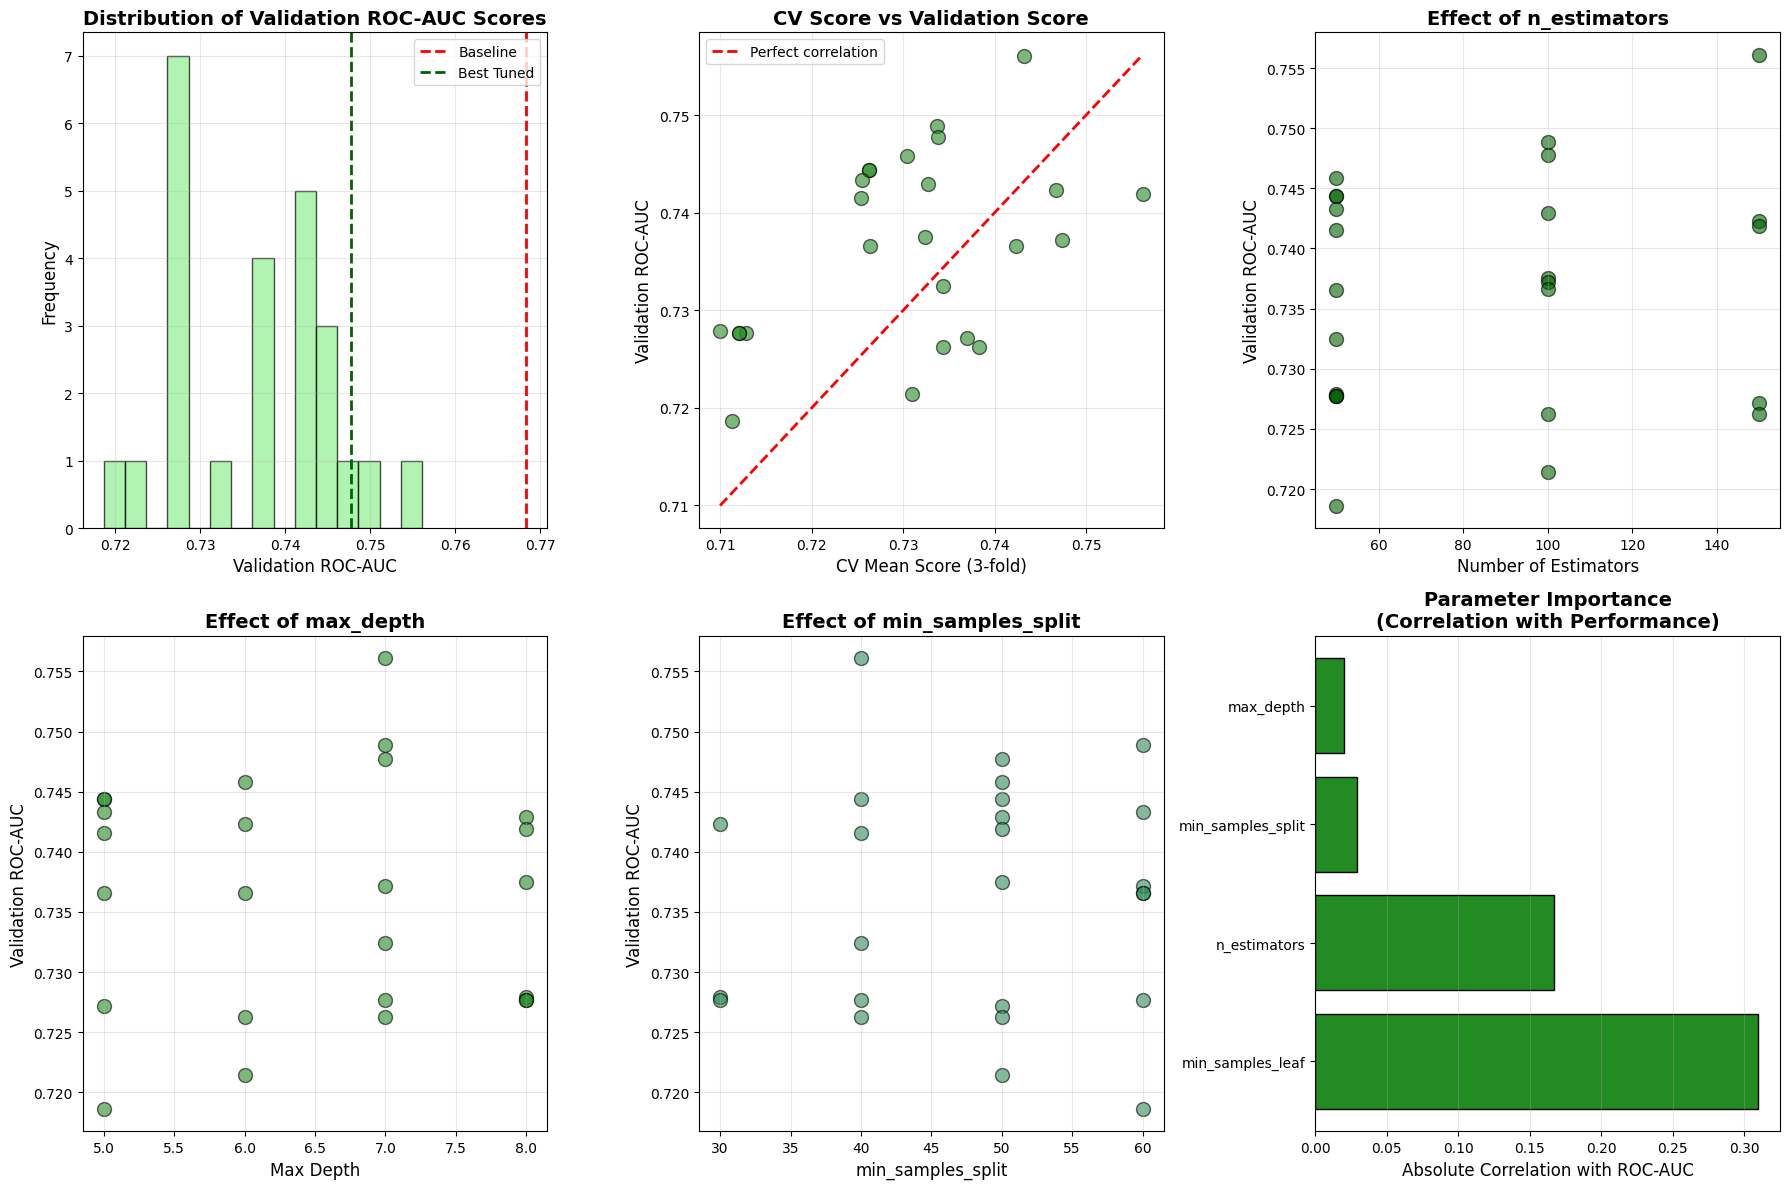


 BEST RANDOM FOREST MODEL PARAMETERS (from RandomizedSearchCV)

Best Parameters:
  n_estimators: 100
  min_samples_split: 50
  min_samples_leaf: 15
  max_features: log2
  max_depth: 7

Validation Metrics:
  val_roc_auc: 0.7477
  val_accuracy: 0.3039
  val_f1_macro: 0.2064
  val_f1_weighted: 0.1808


In [12]:

results_df_rf = pd.DataFrame(results_list_rf)
results_df_rf = results_df_rf.sort_values('val_roc_auc', ascending=False)

print("\n TOP 10 RANDOM FOREST MODELS BY VALIDATION ROC-AUC:")
display_cols = ['cv_mean_score', 'val_roc_auc', 'train_roc_auc', 'overfit_gap', 'val_accuracy', 'val_f1_macro', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
available_cols = [col for col in display_cols if col in results_df_rf.columns]
print(results_df_rf[available_cols].head(10).to_string(index=False))

# Save results to CSV and log as artifact
results_csv_rf = "rf_randomized_search_results.csv"
results_df_rf.to_csv(results_csv_rf, index=False)


# Visualize tuning results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC-AUC distribution
ax1 = axes[0, 0]
ax1.hist(results_df_rf['val_roc_auc'], bins=15, edgecolor='black', alpha=0.7, color='lightgreen')
ax1.axvline(baseline_rf_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.axvline(best_roc_auc_rf, color='darkgreen', linestyle='--', linewidth=2, label='Best Tuned')
ax1.set_xlabel('Validation ROC-AUC', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Validation ROC-AUC Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. CV Score vs Validation Score
ax2 = axes[0, 1]
ax2.scatter(results_df_rf['cv_mean_score'], results_df_rf['val_roc_auc'], 
            alpha=0.6, s=100, c='forestgreen', edgecolors='black')
ax2.plot([results_df_rf['cv_mean_score'].min(), results_df_rf['cv_mean_score'].max()],
            [results_df_rf['cv_mean_score'].min(), results_df_rf['cv_mean_score'].max()],
            'r--', lw=2, label='Perfect correlation')
ax2.set_xlabel('CV Mean Score (3-fold)', fontsize=12)
ax2.set_ylabel('Validation ROC-AUC', fontsize=12)
ax2.set_title('CV Score vs Validation Score', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. n_estimators effect (if available)
ax3 = axes[0, 2]
if 'n_estimators' in results_df_rf.columns:
    ax3.scatter(results_df_rf['n_estimators'], results_df_rf['val_roc_auc'], 
                alpha=0.6, s=100, c='darkgreen', edgecolors='black')
    ax3.set_xlabel('Number of Estimators', fontsize=12)
    ax3.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax3.set_title('Effect of n_estimators', fontsize=14, fontweight='bold')
    ax3.grid(alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'n_estimators data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax3.axis('off')

# 4. max_depth effect (if available)
ax4 = axes[1, 0]
if 'max_depth' in results_df_rf.columns:
    depth_data = results_df_rf[results_df_rf['max_depth'].notna()]
    if len(depth_data) > 0:
        ax4.scatter(depth_data['max_depth'].astype(float), depth_data['val_roc_auc'],
                    alpha=0.6, s=100, c='forestgreen', edgecolors='black')
        ax4.set_xlabel('Max Depth', fontsize=12)
        ax4.set_ylabel('Validation ROC-AUC', fontsize=12)
        ax4.set_title('Effect of max_depth', fontsize=14, fontweight='bold')
        ax4.grid(alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'max_depth data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax4.axis('off')
else:
    ax4.text(0.5, 0.5, 'max_depth data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax4.axis('off')

# 5. min_samples_split effect (if available)
ax5 = axes[1, 1]
if 'min_samples_split' in results_df_rf.columns:
    ax5.scatter(results_df_rf['min_samples_split'], results_df_rf['val_roc_auc'],
                alpha=0.6, s=100, c='seagreen', edgecolors='black')
    ax5.set_xlabel('min_samples_split', fontsize=12)
    ax5.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax5.set_title('Effect of min_samples_split', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'min_samples_split data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax5.axis('off')

# 6. Parameter importance (top parameters by variance in scores)
ax6 = axes[1, 2]
try:
    numeric_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
    param_importance = {}
    
    for param in numeric_params:
        if param in results_df_rf.columns:
            # Calculate correlation between parameter and ROC-AUC
            param_data = results_df_rf[[param, 'val_roc_auc']].dropna()
            if len(param_data) > 1:
                corr = abs(param_data[param].corr(param_data['val_roc_auc']))
                param_importance[param] = corr
    
    if param_importance:
        params_sorted = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)
        params_names = [p[0] for p in params_sorted]
        params_values = [p[1] for p in params_sorted]
        
        ax6.barh(params_names, params_values, color='forestgreen', edgecolor='black')
        ax6.set_xlabel('Absolute Correlation with ROC-AUC', fontsize=12)
        ax6.set_title('Parameter Importance\n(Correlation with Performance)', fontsize=14, fontweight='bold')
        ax6.grid(alpha=0.3, axis='x')
    else:
        ax6.text(0.5, 0.5, 'Parameter importance\nnot available', 
                ha='center', va='center', fontsize=12)
        ax6.axis('off')
except Exception:
    ax6.text(0.5, 0.5, 'Error calculating\nparameter importance', 
            ha='center', va='center', fontsize=12)
    ax6.axis('off')

plt.tight_layout()

# Log visualization as artifact
tuning_viz_path_rf = 'rf_randomized_search_analysis.png'
plt.savefig(tuning_viz_path_rf, dpi=300, bbox_inches='tight')

plt.show()

print("\n" + "="*70)
print(" BEST RANDOM FOREST MODEL PARAMETERS (from RandomizedSearchCV)")
print("="*70)
print("\nBest Parameters:")
for key, value in best_params_rf.items():
    print(f"  {key}: {value}")

print("\nValidation Metrics:")
for key, value in best_metrics_rf.items():
    print(f"  {key}: {value:.4f}")




 FINAL RANDOM FOREST EVALUATION ON TEST SET

Test Set Metrics:
  ROC-AUC (macro):     0.7045
  Accuracy:            0.2601
  F1-Score (macro):    0.0785
  F1-Score (weighted): 0.1247

 Test Classification Report:
              precision    recall  f1-score   support

       angry     1.0000    0.0021    0.0042       958
     disgust     0.0000    0.0000    0.0000       111
        fear     1.0000    0.0010    0.0020      1024
       happy     0.2560    0.9972    0.4074      1774
         sad     0.3191    0.0120    0.0232      1247
    surprise     1.0000    0.0024    0.0048       831
     neutral     0.3697    0.0633    0.1080      1233

    accuracy                         0.2601      7178
   macro avg     0.5635    0.1540    0.0785      7178
weighted avg     0.5741    0.2601    0.1247      7178



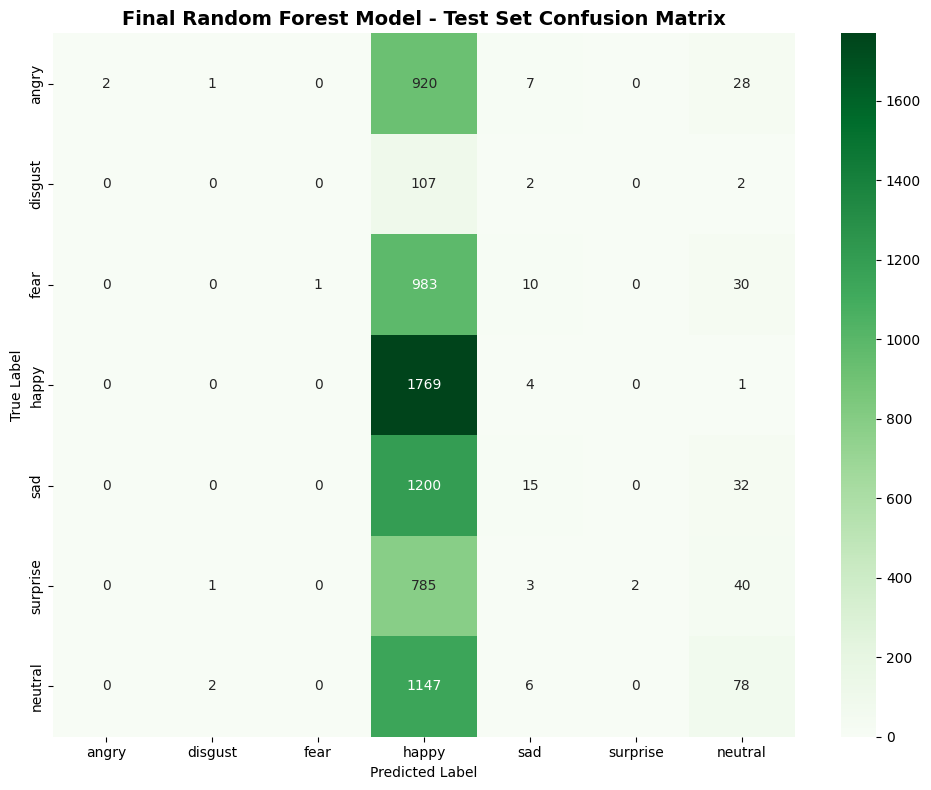

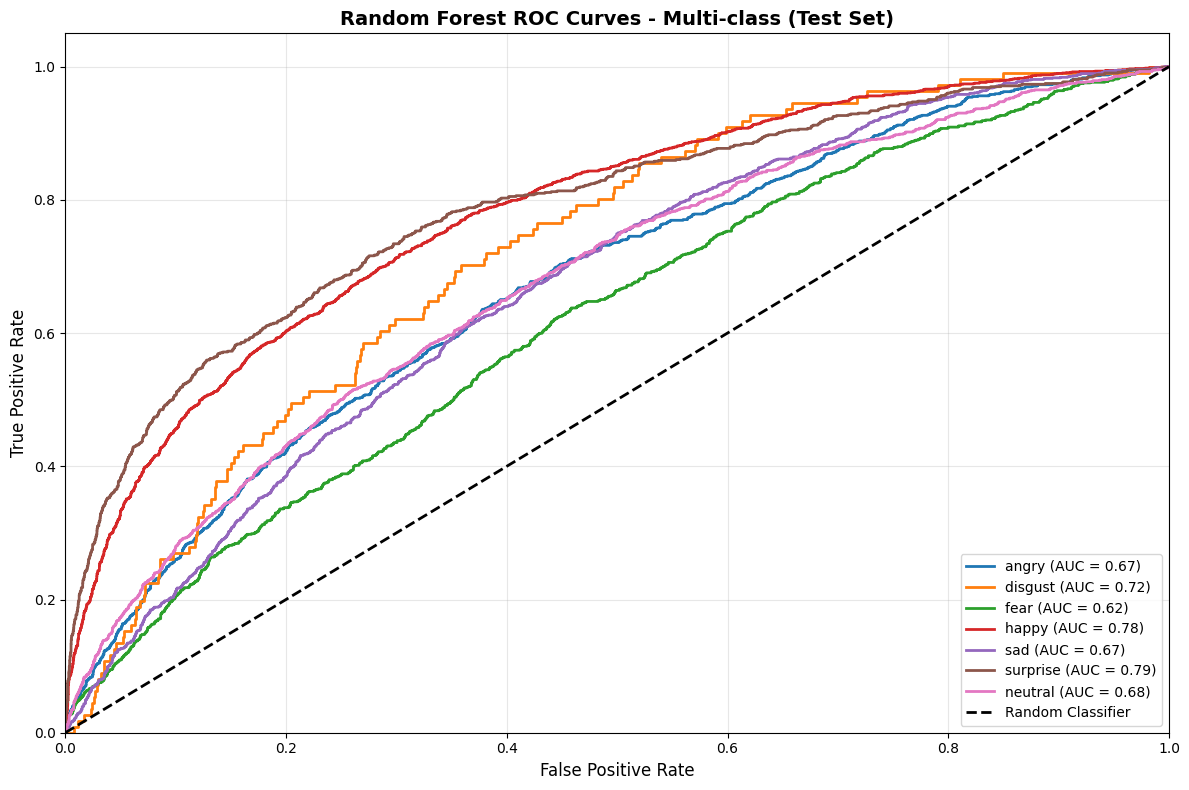

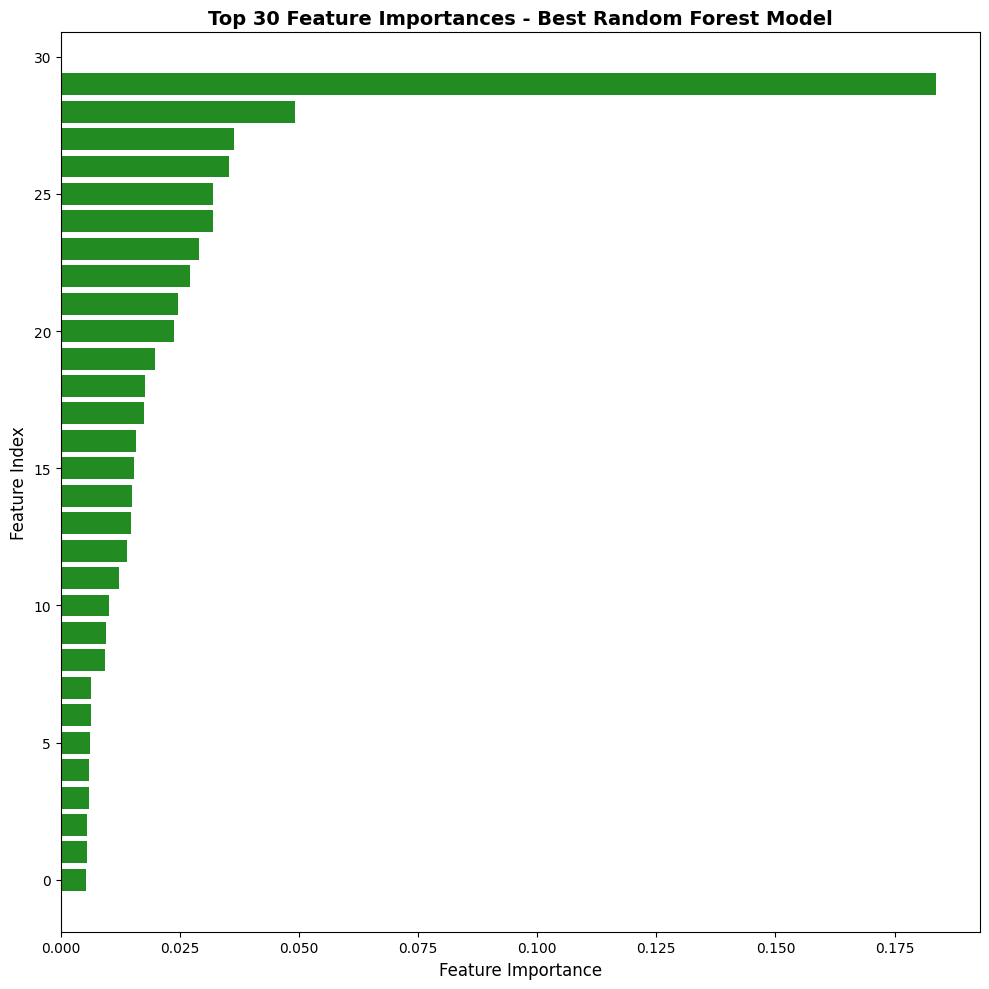


 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   1.000000 0.002088  0.004167      958
 disgust   0.000000 0.000000  0.000000      111
    fear   1.000000 0.000977  0.001951     1024
   happy   0.255969 0.997182  0.407369     1774
     sad   0.319149 0.012029  0.023184     1247
surprise   1.000000 0.002407  0.004802      831
 neutral   0.369668 0.063260  0.108033     1233

 Model saved: models/random_forest_best_20251123_040115.pkl
 Results saved: models/random_forest_results_20251123_040115.json

 RANDOM FOREST TRAINING PIPELINE COMPLETED SUCCESSFULLY

 Final Test Performance:
  ROC-AUC:  0.7045
  Accuracy: 0.2601
  F1-Score: 0.0785
 Model saved as: models/random_forest_best_20251123_040115.pkl


In [ ]:

print("\n" + "="*70)
print(" FINAL RANDOM FOREST EVALUATION ON TEST SET")
print("="*70)

# Preprocess test data (independent)
y_test_bin_rf = label_binarize(y_test, classes=range(n_classes_rf))

# Predict on test set
y_test_pred_rf = best_rf_model.predict(X_test_processed)
y_test_pred_proba_rf = best_rf_model.predict_proba(X_test_processed)

# Calculate all metrics
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_f1_macro_rf = f1_score(y_test, y_test_pred_rf, average='macro')
test_f1_weighted_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
test_roc_auc_rf = roc_auc_score(y_test_bin_rf, y_test_pred_proba_rf, average='macro', multi_class='ovr')

print("\nTest Set Metrics:")
print(f"  ROC-AUC (macro):     {test_roc_auc_rf:.4f}")
print(f"  Accuracy:            {test_accuracy_rf:.4f}")
print(f"  F1-Score (macro):    {test_f1_macro_rf:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted_rf:.4f}")

# Classification report
print("\n Test Classification Report:")
report_test_rf = classification_report(y_test, y_test_pred_rf, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_test, y_test_pred_rf, target_names=emotion_labels, digits=4))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final Random Forest Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix
test_cm_path_rf = 'rf_test_confusion_matrix.png'
plt.savefig(test_cm_path_rf, dpi=300, bbox_inches='tight')

plt.show()

# ROC Curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes_rf):
    fpr, tpr, _ = roc_curve(y_test_bin_rf[:, i], y_test_pred_proba_rf[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Log ROC curves
roc_path_rf = 'rf_test_roc_curves.png'
plt.savefig(roc_path_rf, dpi=300, bbox_inches='tight')

plt.show()

# Feature importance of best model
feature_importance_best = best_rf_model.feature_importances_
top_n = 30
top_indices_best = np.argsort(feature_importance_best)[-top_n:]

plt.figure(figsize=(10, 10))
plt.barh(range(top_n), feature_importance_best[top_indices_best], color='forestgreen')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature Index', fontsize=12)
plt.title(f'Top {top_n} Feature Importances - Best Random Forest Model', fontsize=14, fontweight='bold')
plt.tight_layout()

feat_imp_best_path = 'rf_best_feature_importance.png'
plt.savefig(feat_imp_best_path, dpi=300, bbox_inches='tight')

plt.show()

# Per-class metrics table
print("\n Per-Class Metrics:")
class_metrics_rf = []
for i, emotion in enumerate(emotion_labels):
    precision = cm_rf[i, i] / cm_rf[:, i].sum() if cm_rf[:, i].sum() > 0 else 0
    recall = cm_rf[i, i] / cm_rf[i, :].sum() if cm_rf[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics_rf.append({
        'Emotion': emotion,
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'Support': int(cm_rf[i, :].sum())
    })

class_metrics_df_rf = pd.DataFrame(class_metrics_rf)
print(class_metrics_df_rf.to_string(index=False))

# Save and log class metrics
class_metrics_csv_rf = "rf_test_class_metrics.csv"
class_metrics_df_rf.to_csv(class_metrics_csv_rf, index=False)


# Save final model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename_rf = f'models/random_forest_best_{timestamp}.pkl'
joblib.dump(best_rf_model, model_filename_rf)
print(f"\n Model saved: {model_filename_rf}")




# Save complete results
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

final_results_rf = {
    'model_name': 'Random Forest',
    'timestamp': timestamp,
    'best_params': convert_to_native_types(best_params_rf),
    'best_run_id': best_run_id_rf,
    'validation_metrics': convert_to_native_types(best_metrics_rf),
    'test_metrics': {
        'roc_auc': float(test_roc_auc_rf),
        'accuracy': float(test_accuracy_rf),
        'f1_macro': float(test_f1_macro_rf),
        'f1_weighted': float(test_f1_weighted_rf)
    },
    'per_class_metrics': class_metrics_rf,
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'feature_dimension': int(X_train_processed.shape[1]),
    'emotion_labels': emotion_labels
}

results_filename_rf = f'models/random_forest_results_{timestamp}.json'
with open(results_filename_rf, 'w') as f:
    json.dump(final_results_rf, f, indent=4)
print(f" Results saved: {results_filename_rf}")

print("\n" + "="*70)
print(" RANDOM FOREST TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print("\n Final Test Performance:")
print(f"  ROC-AUC:  {test_roc_auc_rf:.4f}")
print(f"  Accuracy: {test_accuracy_rf:.4f}")
print(f"  F1-Score: {test_f1_macro_rf:.4f}")

print(f" Model saved as: {model_filename_rf}")


# SVM


 STEP 1: BASELINE SVM MODEL TRAINING (Anti-Overfitting)

 Training baseline SVM model...
   Parameters: C=0.1, kernel=linear, class_weight=balanced
   Anti-overfitting measures:
      → Linear kernel (simpler than RBF)
      → C=0.1 (10x stronger regularization)
      → Balanced class weights
[LibSVM] Training completed!

 Training Set Performance:
 Training completed!

 Training Set Performance:
   ROC-AUC (macro):     0.8270
   Accuracy:            0.4937
   F1-Score (macro):    0.5081
   F1-Score (weighted): 0.4920

 Validation Set Performance:
   ROC-AUC (macro):     0.8270
   Accuracy:            0.4937
   F1-Score (macro):    0.5081
   F1-Score (weighted): 0.4920

 Validation Set Performance:
   ROC-AUC (macro):     0.7827
   Accuracy:            0.4337
   F1-Score (macro):    0.4510
   F1-Score (weighted): 0.4341

 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.2802    0.3542    0.3129       799
     disgust     0.780

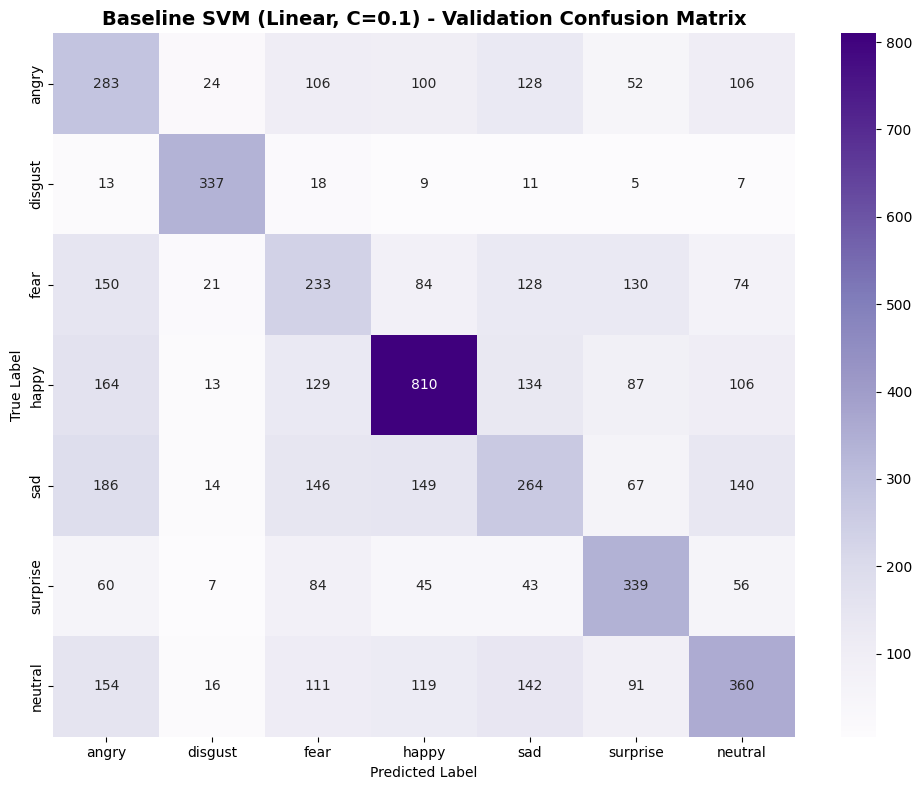


 BASELINE SVM MODEL EVALUATION COMPLETED

 Baseline Performance Summary:
   Training ROC-AUC:   0.8270
   Validation ROC-AUC: 0.7827
   Difference (Gap):   0.0442
      Good! Gap < 0.05 - Model generalizes well

 Next steps to try if still overfitting:
   1. Reduce C further (try 0.01, 0.001)
   2. Increase PCA variance to 0.75-0.80
   3. Add more data augmentation
   4. Try polynomial kernel with degree=2


In [ ]:
# STEP 1: Train baseline SVM model with REDUCED OVERFITTING
print("\n" + "="*70)
print(" STEP 1: BASELINE SVM MODEL TRAINING (Anti-Overfitting)")
print("="*70)

# Prepare data for SVM (independent)
n_classes_svm = len(emotion_labels)
y_val_bin_svm = label_binarize(y_val, classes=range(n_classes_svm))
y_train_bin_svm = label_binarize(y_train, classes=range(n_classes_svm))

baseline_svm = SVC(
    C=0.1,  
    kernel='linear',  
    class_weight='balanced',
    probability=True,  # Enable probability estimates for ROC-AUC
    random_state=42,
    verbose=True
)

print("\n Training baseline SVM model...")
print("   Parameters: C=0.1, kernel=linear, class_weight=balanced")
print("   Anti-overfitting measures:")
print("      → Linear kernel (simpler than RBF)")
print("      → C=0.1 (10x stronger regularization)")
print("      → Balanced class weights")

baseline_svm.fit(X_train_processed, y_train)
print(" Training completed!")

# Evaluate on training set
print("\n Training Set Performance:")
y_train_pred_svm = baseline_svm.predict(X_train_processed)
y_train_pred_proba_svm = baseline_svm.predict_proba(X_train_processed)

train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
train_f1_macro_svm = f1_score(y_train, y_train_pred_svm, average='macro')
train_f1_weighted_svm = f1_score(y_train, y_train_pred_svm, average='weighted')
train_roc_auc_svm = roc_auc_score(y_train_bin_svm, y_train_pred_proba_svm, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {train_roc_auc_svm:.4f}")
print(f"   Accuracy:            {train_accuracy_svm:.4f}")
print(f"   F1-Score (macro):    {train_f1_macro_svm:.4f}")
print(f"   F1-Score (weighted): {train_f1_weighted_svm:.4f}")

# Evaluate on validation set
print("\n Validation Set Performance:")
y_val_pred_svm = baseline_svm.predict(X_val_processed)
y_val_pred_proba_svm = baseline_svm.predict_proba(X_val_processed)

val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
val_f1_macro_svm = f1_score(y_val, y_val_pred_svm, average='macro')
val_f1_weighted_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
val_roc_auc_svm = roc_auc_score(y_val_bin_svm, y_val_pred_proba_svm, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {val_roc_auc_svm:.4f}")
print(f"   Accuracy:            {val_accuracy_svm:.4f}")
print(f"   F1-Score (macro):    {val_f1_macro_svm:.4f}")
print(f"   F1-Score (weighted): {val_f1_weighted_svm:.4f}")

# Classification report
print("\n Validation Classification Report:")
report_svm = classification_report(y_val, y_val_pred_svm, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_val, y_val_pred_svm, target_names=emotion_labels, digits=4))

# Confusion matrix visualization
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_svm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Baseline SVM (Linear, C=0.1) - Validation Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix as artifact
cm_path_svm = "baseline_svm_confusion_matrix.png"
plt.savefig(cm_path_svm, dpi=300, bbox_inches='tight')

plt.show()

# Store baseline results
baseline_svm_results = {
    'model_config': {
        'kernel': 'linear',
        'C': 0.1,
        'class_weight': 'balanced'
    },
    'train': {
        'roc_auc': train_roc_auc_svm,
        'accuracy': train_accuracy_svm,
        'f1_macro': train_f1_macro_svm,
        'f1_weighted': train_f1_weighted_svm
    },
    'validation': {
        'roc_auc': val_roc_auc_svm,
        'accuracy': val_accuracy_svm,
        'f1_macro': val_f1_macro_svm,
        'f1_weighted': val_f1_weighted_svm
    }
}

# Log baseline results as JSON artifact
baseline_svm_json = "baseline_svm_results.json"
with open(baseline_svm_json, 'w') as f:
    json.dump(baseline_svm_results, f, indent=4)

print("\n" + "="*70)
print(" BASELINE SVM MODEL EVALUATION COMPLETED")
print("="*70)
print("\n Baseline Performance Summary:")
print(f"   Training ROC-AUC:   {train_roc_auc_svm:.4f}")
print(f"   Validation ROC-AUC: {val_roc_auc_svm:.4f}")
print(f"   Difference (Gap):   {abs(train_roc_auc_svm - val_roc_auc_svm):.4f}")

# Log overfitting metric
overfitting_gap_svm = train_roc_auc_svm - val_roc_auc_svm

if overfitting_gap_svm > 0.05:
    print(f"     Warning: Overfitting detected (gap = {overfitting_gap_svm:.4f})")
    print("      → Consider: Further reduce C, increase regularization")
elif overfitting_gap_svm < 0:
    print(f"     Note: Validation better than training (gap = {overfitting_gap_svm:.4f})")
    print("      → This is unusual but can happen with small datasets")
else:
    print("      Good! Gap < 0.05 - Model generalizes well")

print("\n Next steps to try if still overfitting:")
print("   1. Reduce C further (try 0.01, 0.001)")
print("   2. Increase PCA variance to 0.75-0.80")
print("   3. Add more data augmentation")
print("   4. Try polynomial kernel with degree=2")

In [ ]:
# STEP 2: Hyperparameter Tuning for SVM using RandomizedSearchCV (Optimized)
print("\n" + "="*70)
print(" STEP 2: HYPERPARAMETER TUNING FOR SVM (ANTI-OVERFITTING + FAST)")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

param_distributions_svm = {
    'C': [0.01, 0.05, 0.1, 0.5],  # CHANGED: Lower C values for regularization
    'kernel': ['linear'],  # CHANGED: Only linear for speed and less overfitting
    
}

# Alternative: If you want to try RBF (slower but potentially better)
param_distributions_svm_rbf = {
    'C': [0.01, 0.1, 0.5],  # Lower C values
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1]  # Lower gamma values for less overfitting
}

# Alternative: Balanced approach (linear + poly)
param_distributions_svm_balanced = {
    'C': [0.01, 0.05, 0.1, 0.5, 1.0],
    'kernel': ['linear', 'poly'],
    'degree': [2, 3],  # Only for poly kernel
    'gamma': ['scale']  # Only for poly kernel
}

print("\n RECOMMENDED: Fast Linear Search (chosen)")
print("   C values: [0.01, 0.05, 0.1, 0.5] - Strong to moderate regularization")
print("   Kernel: ['linear'] - Fast and less prone to overfitting")
print("   Expected time: ~5-10 minutes")

print("\n ALTERNATIVE 1: RBF Search (if you want to try, slower)")
print("   C values: [0.01, 0.1, 0.5] - Stronger regularization than baseline")
print("   Gamma: [0.001, 0.01, 0.1] - Lower values to reduce overfitting")
print("   Expected time: ~30-60 minutes")

print("\n ALTERNATIVE 2: Balanced Search (linear + polynomial)")
print("   Includes both linear and polynomial degree 2-3")
print("   Expected time: ~15-20 minutes")

# Choose which distribution to use (uncomment to switch)
# param_distributions_svm = param_distributions_svm_rbf  # For RBF
# param_distributions_svm = param_distributions_svm_balanced  # For balanced

print("\n Selected Parameter Distributions:")
for param, dist in param_distributions_svm.items():
    print(f"   {param}: {dist}")

n_iter_svm = 4  # CHANGED: Reduced from 10 to 4 (we have only 4 C values with 1 kernel)
print(f"\nRandomized Search iterations: {n_iter_svm} (optimized)")
print(f"Baseline ROC-AUC to beat: {val_roc_auc_svm:.4f}")
print(f"Baseline had OVERFITTING gap: {abs(train_roc_auc_svm - val_roc_auc_svm):.4f}")
print("   → Goal: Reduce gap to < 0.05 while maintaining validation score\n")

# Create RandomizedSearchCV
svm_random = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42, class_weight='balanced', verbose=0),
    param_distributions=param_distributions_svm,
    n_iter=n_iter_svm,
    cv=3,  # 3-fold cross-validation on training data
    scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
    n_jobs=-1,  # Use all CPU cores for parallel processing
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV with AUGMENTED data
print(" Running RandomizedSearchCV with AUGMENTED data...")
print("   Using all CPU cores (n_jobs=-1) for parallel processing")
print("   This should complete in ~5-10 minutes with linear kernel...\n")

svm_random.fit(X_train_processed, y_train)
print("\n RandomizedSearchCV completed!")

# Get results
cv_results = pd.DataFrame(svm_random.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

results_list_svm = []
best_roc_auc_svm = val_roc_auc_svm
best_svm_model = baseline_svm
best_run_id_svm = None
best_params_svm = {}  # Initialize to prevent NameError
best_metrics_svm = {  # Initialize with baseline metrics
    'val_roc_auc': val_roc_auc_svm,
    'val_accuracy': val_accuracy_svm,
    'val_f1_macro': val_f1_macro_svm,
    'val_f1_weighted': val_f1_weighted_svm
}

print("\n Evaluating each model on validation set...")
for idx in range(len(cv_results)):
    row = cv_results.iloc[idx]
    
    # Extract parameters
    params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
    
    # Get the model from CV
    model_idx = row['rank_test_score'] - 1
    model_svm = svm_random.cv_results_['params'][model_idx]
    fitted_model = SVC(**model_svm, probability=True, random_state=42, class_weight='balanced', verbose=0)
    fitted_model.fit(X_train_processed, y_train)
    
    # Evaluate on TRAINING set (to check overfitting)
    y_train_pred = fitted_model.predict(X_train_processed)
    y_train_pred_proba = fitted_model.predict_proba(X_train_processed)
    train_roc_auc = roc_auc_score(y_train_bin_svm, y_train_pred_proba, average='macro', multi_class='ovr')
    
    # Evaluate on VALIDATION set
    y_val_pred = fitted_model.predict(X_val_processed)
    y_val_pred_proba = fitted_model.predict_proba(X_val_processed)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val_bin_svm, y_val_pred_proba, average='macro', multi_class='ovr')
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    
    # Calculate overfitting gap
    overfit_gap = train_roc_auc - roc_auc
    
    # Store results
    result = {
        **params,
        'cv_mean_score': row['mean_test_score'],
        'train_roc_auc': train_roc_auc,
        'val_roc_auc': roc_auc,
        'overfit_gap': overfit_gap,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    results_list_svm.append(result)
    
    # Update best model (prioritize low overfitting + high validation score)
    if roc_auc > best_roc_auc_svm:
        improvement = roc_auc - best_roc_auc_svm
        best_roc_auc_svm = roc_auc
        best_svm_model = fitted_model
        best_params_svm = params
        best_metrics_svm = {
            'train_roc_auc': train_roc_auc,
            'val_roc_auc': roc_auc,
            'val_accuracy': accuracy,
            'val_f1_macro': f1_macro,
            'val_f1_weighted': f1_weighted,
            'overfit_gap': overfit_gap
        }
        
        print(f"\n New best SVM model found! (+{improvement:.4f})")
        print(f"   Params: {params}")
        print(f"   Train ROC-AUC: {train_roc_auc:.4f} | Val ROC-AUC: {roc_auc:.4f}")
        print(f"   Overfit Gap: {overfit_gap:.4f} (baseline: 0.1480)")
        print(f"   Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
        print(f"   CV Score: {row['mean_test_score']:.4f}")

# Save CV results
cv_results_path = "svm_cv_results.csv"
cv_results.to_csv(cv_results_path, index=False)

print("\n" + "="*70)
print(" RANDOMIZED HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement_svm = best_roc_auc_svm - baseline_svm_results['validation']['roc_auc']
baseline_gap = train_roc_auc_svm - val_roc_auc_svm
best_gap = best_metrics_svm['overfit_gap']

print("\n Tuning Results:")
print(f"   Baseline Val ROC-AUC:     {baseline_svm_results['validation']['roc_auc']:.4f}")
print(f"   Baseline Overfit Gap:     {baseline_gap:.4f}")
print(f"\n   Best CV ROC-AUC:          {svm_random.best_score_:.4f}")
print(f"   Best Val ROC-AUC:         {best_roc_auc_svm:.4f}")
print(f"   Best Overfit Gap:         {best_gap:.4f}")
print(f"\n   Improvement:              {improvement_svm:.4f} ({improvement_svm/baseline_svm_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Gap Reduction:            {baseline_gap - best_gap:.4f}")
print(f"   Iterations completed:     {n_iter_svm}")

if best_gap < 0.05:
    print("\n    SUCCESS! Overfitting reduced to acceptable level (< 0.05)")
elif best_gap < baseline_gap:
    print(f"\n    IMPROVED! Overfitting reduced by {baseline_gap - best_gap:.4f}")
else:
    print("\n    Note: Consider reducing C further or using only linear kernel")

print(f"\n Best Model Parameters:")
for param, value in best_params_svm.items():
    print(f"   {param}: {value}")


 STEP 2: HYPERPARAMETER TUNING FOR SVM (ANTI-OVERFITTING + FAST)

 RECOMMENDED: Fast Linear Search (chosen)
   C values: [0.01, 0.05, 0.1, 0.5] - Strong to moderate regularization
   Kernel: ['linear'] - Fast and less prone to overfitting
   Expected time: ~5-10 minutes

 ALTERNATIVE 1: RBF Search (if you want to try, slower)
   C values: [0.01, 0.1, 0.5] - Stronger regularization than baseline
   Gamma: [0.001, 0.01, 0.1] - Lower values to reduce overfitting
   Expected time: ~30-60 minutes

 ALTERNATIVE 2: Balanced Search (linear + polynomial)
   Includes both linear and polynomial degree 2-3
   Expected time: ~15-20 minutes

 Selected Parameter Distributions:
   C: [0.01, 0.05, 0.1, 0.5]
   kernel: ['linear']

Randomized Search iterations: 4 (optimized)
Baseline ROC-AUC to beat: 0.7827
Baseline had OVERFITTING gap: 0.0442
   → Goal: Reduce gap to < 0.05 while maintaining validation score

 Running RandomizedSearchCV with AUGMENTED data...
   Using all CPU cores (n_jobs=-1) for para


 TOP 10 SVM MODELS BY VALIDATION ROC-AUC:
 cv_mean_score  train_roc_auc  val_roc_auc  overfit_gap  accuracy  f1_macro    C kernel
      0.777779       0.828372     0.785388     0.042984  0.432700  0.449922 0.01 linear
      0.773738       0.827439     0.783418     0.044021  0.434517  0.451511 0.05 linear
      0.771960       0.826986     0.782746     0.044240  0.433691  0.451039 0.10 linear
      0.767703       0.825744     0.781159     0.044585  0.433526  0.450784 0.50 linear

 Detailed Results:
   Total models tested: 4
   Best validation ROC-AUC: 0.7854
   Mean validation ROC-AUC: 0.7832
   Std validation ROC-AUC:  0.0018
   Best overfitting gap:    0.0430


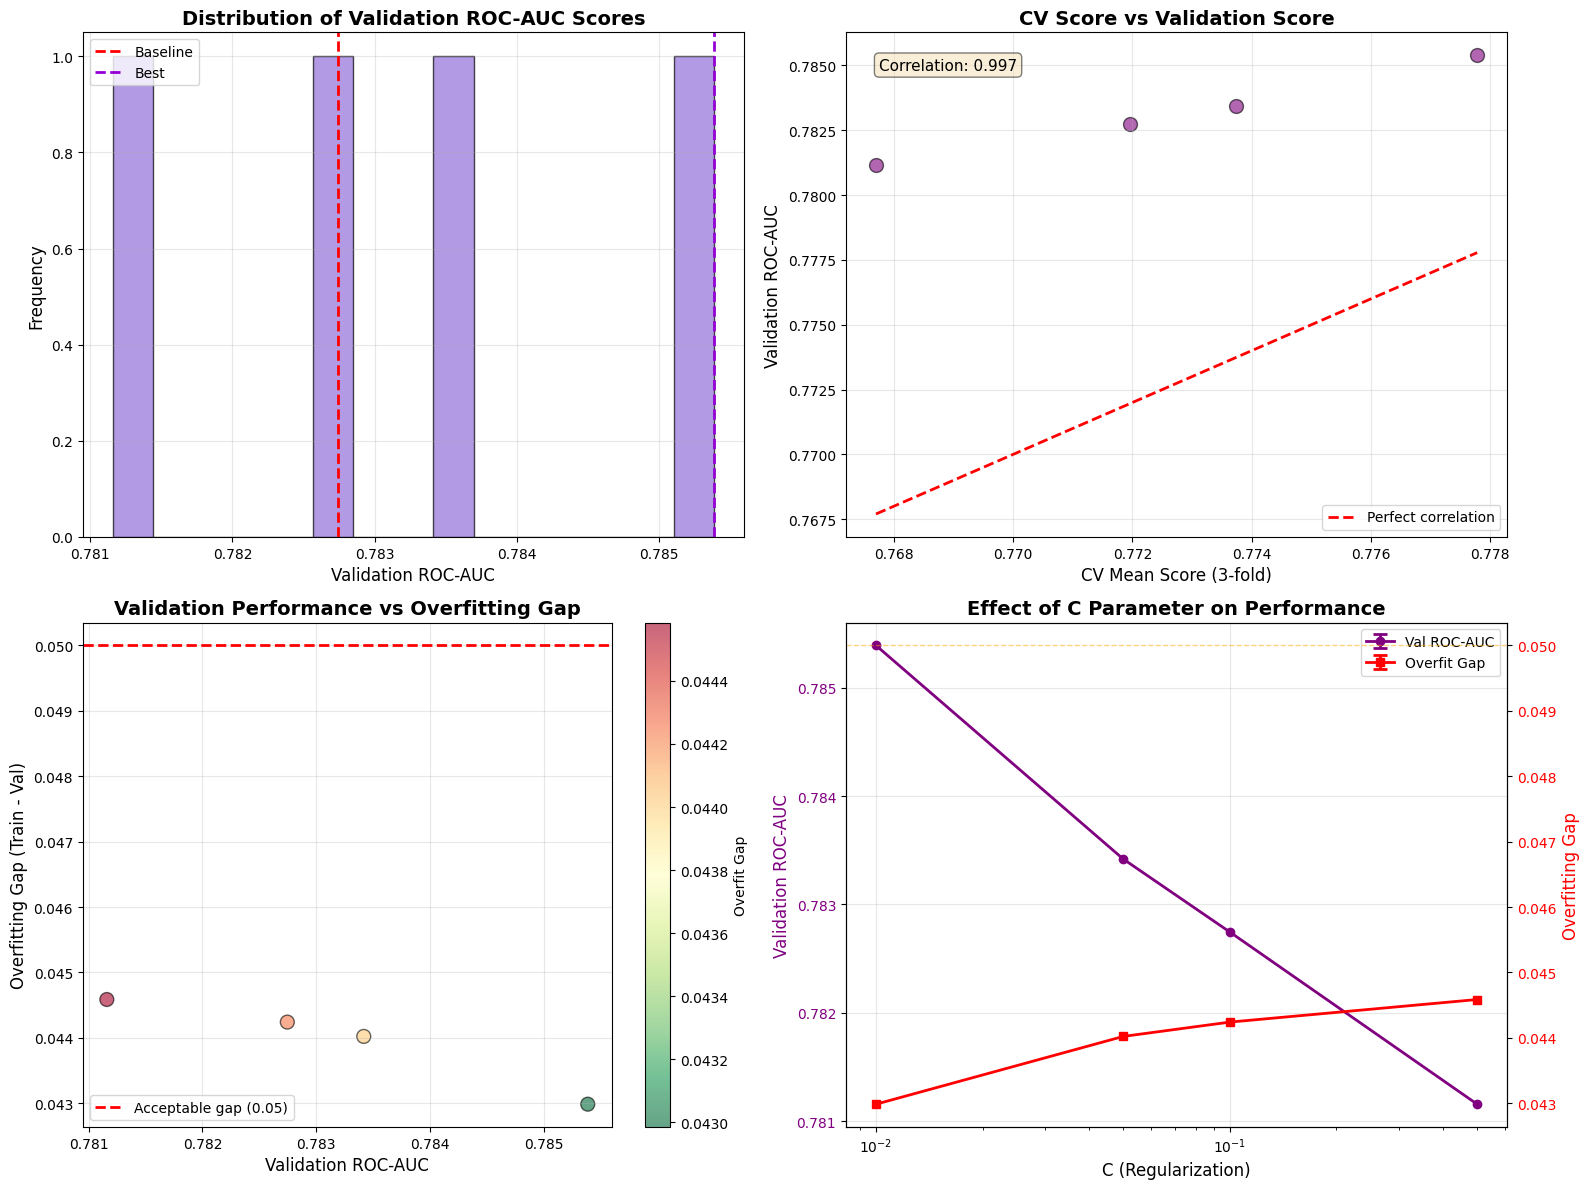


 BEST SVM MODEL PARAMETERS (from RandomizedSearchCV)

Best Parameters:
   kernel: linear
   C: 0.01

Best Model Performance:
   Training ROC-AUC:     0.8284
   Validation ROC-AUC:   0.7854
   Overfitting Gap:      0.0430
   Validation Accuracy:  0.4327
   Validation F1-Macro:  0.4499
   Validation F1-Weight: 0.4334

    SUCCESS! Model generalizes well (gap < 0.05)


In [17]:


results_df_svm = pd.DataFrame(results_list_svm)
results_df_svm = results_df_svm.sort_values('val_roc_auc', ascending=False)  # FIXED: Changed from 'roc_auc' to 'val_roc_auc'

print("\n TOP 10 SVM MODELS BY VALIDATION ROC-AUC:")
# Updated display columns to match new schema
display_cols = ['cv_mean_score', 'train_roc_auc', 'val_roc_auc', 'overfit_gap', 'accuracy', 'f1_macro', 'C', 'kernel']
available_cols = [col for col in display_cols if col in results_df_svm.columns]
print(results_df_svm[available_cols].head(10).to_string(index=False))

# Save results to CSV and log as artifact
results_csv_svm = "svm_randomized_search_results.csv"
results_df_svm.to_csv(results_csv_svm, index=False)

print("\n Detailed Results:")
print(f"   Total models tested: {len(results_df_svm)}")
print(f"   Best validation ROC-AUC: {results_df_svm['val_roc_auc'].max():.4f}")
print(f"   Mean validation ROC-AUC: {results_df_svm['val_roc_auc'].mean():.4f}")
print(f"   Std validation ROC-AUC:  {results_df_svm['val_roc_auc'].std():.4f}")
print(f"   Best overfitting gap:    {results_df_svm['overfit_gap'].min():.4f}")

# Visualize tuning results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC-AUC distribution
ax1 = axes[0, 0]
ax1.hist(results_df_svm['val_roc_auc'], bins=15, edgecolor='black', alpha=0.7, color='mediumpurple')
ax1.axvline(baseline_svm_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.axvline(best_roc_auc_svm, color='darkviolet', linestyle='--', linewidth=2, label='Best')
ax1.set_xlabel('Validation ROC-AUC', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Validation ROC-AUC Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. CV Score vs Validation Score
ax2 = axes[0, 1]
ax2.scatter(results_df_svm['cv_mean_score'], results_df_svm['val_roc_auc'], 
            alpha=0.6, s=100, c='purple', edgecolors='black')
ax2.plot([results_df_svm['cv_mean_score'].min(), results_df_svm['cv_mean_score'].max()],
         [results_df_svm['cv_mean_score'].min(), results_df_svm['cv_mean_score'].max()],
         'r--', lw=2, label='Perfect correlation')
ax2.set_xlabel('CV Mean Score (3-fold)', fontsize=12)
ax2.set_ylabel('Validation ROC-AUC', fontsize=12)
ax2.set_title('CV Score vs Validation Score', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Calculate correlation
corr = results_df_svm[['cv_mean_score', 'val_roc_auc']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Overfitting Gap Analysis (NEW)
ax3 = axes[1, 0]
if 'overfit_gap' in results_df_svm.columns:
    scatter = ax3.scatter(results_df_svm['val_roc_auc'], results_df_svm['overfit_gap'], 
                         alpha=0.6, s=100, c=results_df_svm['overfit_gap'], 
                         cmap='RdYlGn_r', edgecolors='black')
    ax3.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Acceptable gap (0.05)')
    ax3.set_xlabel('Validation ROC-AUC', fontsize=12)
    ax3.set_ylabel('Overfitting Gap (Train - Val)', fontsize=12)
    ax3.set_title('Validation Performance vs Overfitting Gap', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Overfit Gap')
else:
    ax3.text(0.5, 0.5, 'Overfitting gap data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax3.axis('off')

# 4. C parameter effect
ax4 = axes[1, 1]
if 'C' in results_df_svm.columns:
    c_effect = results_df_svm.groupby('C').agg({
        'val_roc_auc': ['mean', 'std'],
        'overfit_gap': ['mean', 'std']
    }).reset_index()
    
    ax4_twin = ax4.twinx()
    
    # Plot validation ROC-AUC
    line1 = ax4.errorbar(c_effect['C'], c_effect[('val_roc_auc', 'mean')], 
                        yerr=c_effect[('val_roc_auc', 'std')], 
                        marker='o', capsize=5, capthick=2, linewidth=2, 
                        color='purple', label='Val ROC-AUC')
    ax4.set_xlabel('C (Regularization)', fontsize=12)
    ax4.set_ylabel('Validation ROC-AUC', fontsize=12, color='purple')
    ax4.tick_params(axis='y', labelcolor='purple')
    
    # Plot overfitting gap on secondary axis
    if 'overfit_gap' in results_df_svm.columns:
        line2 = ax4_twin.errorbar(c_effect['C'], c_effect[('overfit_gap', 'mean')], 
                                 yerr=c_effect[('overfit_gap', 'std')], 
                                 marker='s', capsize=5, capthick=2, linewidth=2, 
                                 color='red', label='Overfit Gap')
        ax4_twin.set_ylabel('Overfitting Gap', fontsize=12, color='red')
        ax4_twin.tick_params(axis='y', labelcolor='red')
        ax4_twin.axhline(0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    
    ax4.set_xscale('log')
    ax4.set_title('Effect of C Parameter on Performance', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3, axis='both')
    
    # Combine legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='best')
else:
    ax4.text(0.5, 0.5, 'C parameter data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax4.axis('off')

plt.tight_layout()

# Log visualization as artifact
tuning_viz_path_svm = 'svm_randomized_search_analysis.png'
plt.savefig(tuning_viz_path_svm, dpi=300, bbox_inches='tight')

plt.show()

print("\n" + "="*70)
print(" BEST SVM MODEL PARAMETERS (from RandomizedSearchCV)")
print("="*70)
print("\nBest Parameters:")
for key, value in best_params_svm.items():
    print(f"   {key}: {value}")

print("\nBest Model Performance:")
print(f"   Training ROC-AUC:     {best_metrics_svm['train_roc_auc']:.4f}")
print(f"   Validation ROC-AUC:   {best_metrics_svm['val_roc_auc']:.4f}")
print(f"   Overfitting Gap:      {best_metrics_svm['overfit_gap']:.4f}")
print(f"   Validation Accuracy:  {best_metrics_svm['val_accuracy']:.4f}")
print(f"   Validation F1-Macro:  {best_metrics_svm['val_f1_macro']:.4f}")
print(f"   Validation F1-Weight: {best_metrics_svm['val_f1_weighted']:.4f}")

if best_metrics_svm['overfit_gap'] < 0.05:
    print("\n    SUCCESS! Model generalizes well (gap < 0.05)")
elif best_metrics_svm['overfit_gap'] < 0.10:
    print("\n    GOOD! Acceptable overfitting level (gap < 0.10)")
else:
    print(f"\n    WARNING! Still overfitting (gap = {best_metrics_svm['overfit_gap']:.4f})")
    print("      → Consider: Further reduce C or try only linear kernel")


 FINAL SVM EVALUATION ON TEST SET

Test Set Metrics:
  ROC-AUC (macro):     0.7629
  Accuracy:            0.4036
  F1-Score (macro):    0.3623
  F1-Score (weighted): 0.4037

 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.2841    0.3653    0.3196       958
     disgust     0.1579    0.2162    0.1825       111
        fear     0.2867    0.2705    0.2784      1024
       happy     0.6221    0.5846    0.6027      1774
         sad     0.2845    0.2430    0.2621      1247
    surprise     0.4804    0.5608    0.5175       831
     neutral     0.3908    0.3569    0.3730      1233

    accuracy                         0.4036      7178
   macro avg     0.3581    0.3710    0.3623      7178
weighted avg     0.4072    0.4036    0.4037      7178


Test Set Metrics:
  ROC-AUC (macro):     0.7629
  Accuracy:            0.4036
  F1-Score (macro):    0.3623
  F1-Score (weighted): 0.4037

 Test Classification Report:
              precision    rec

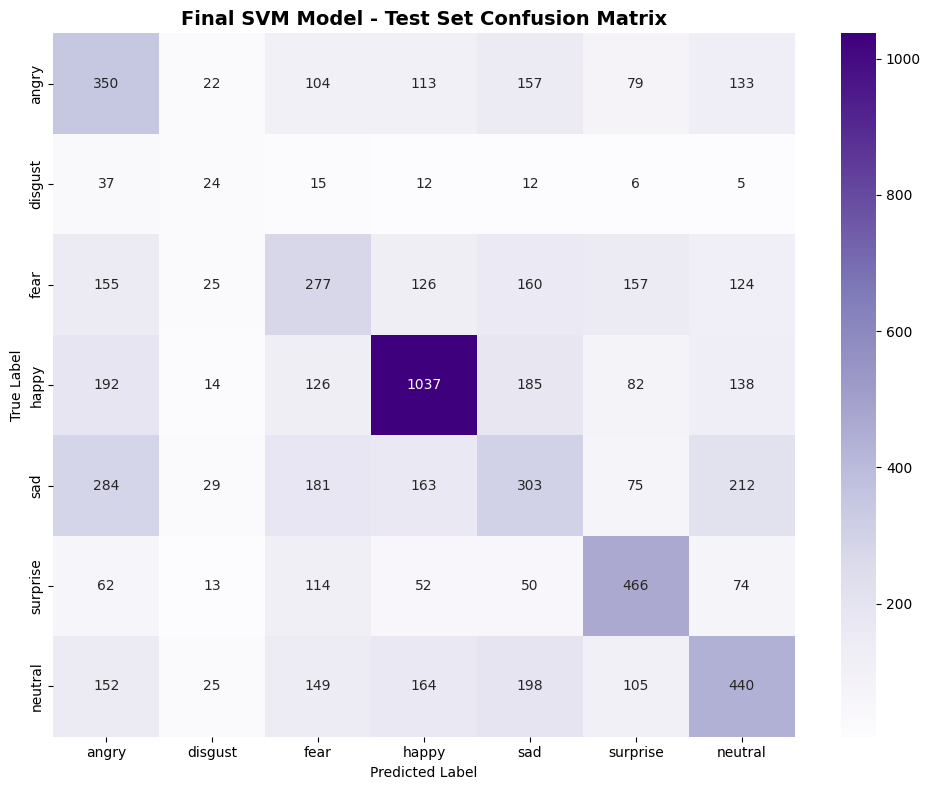

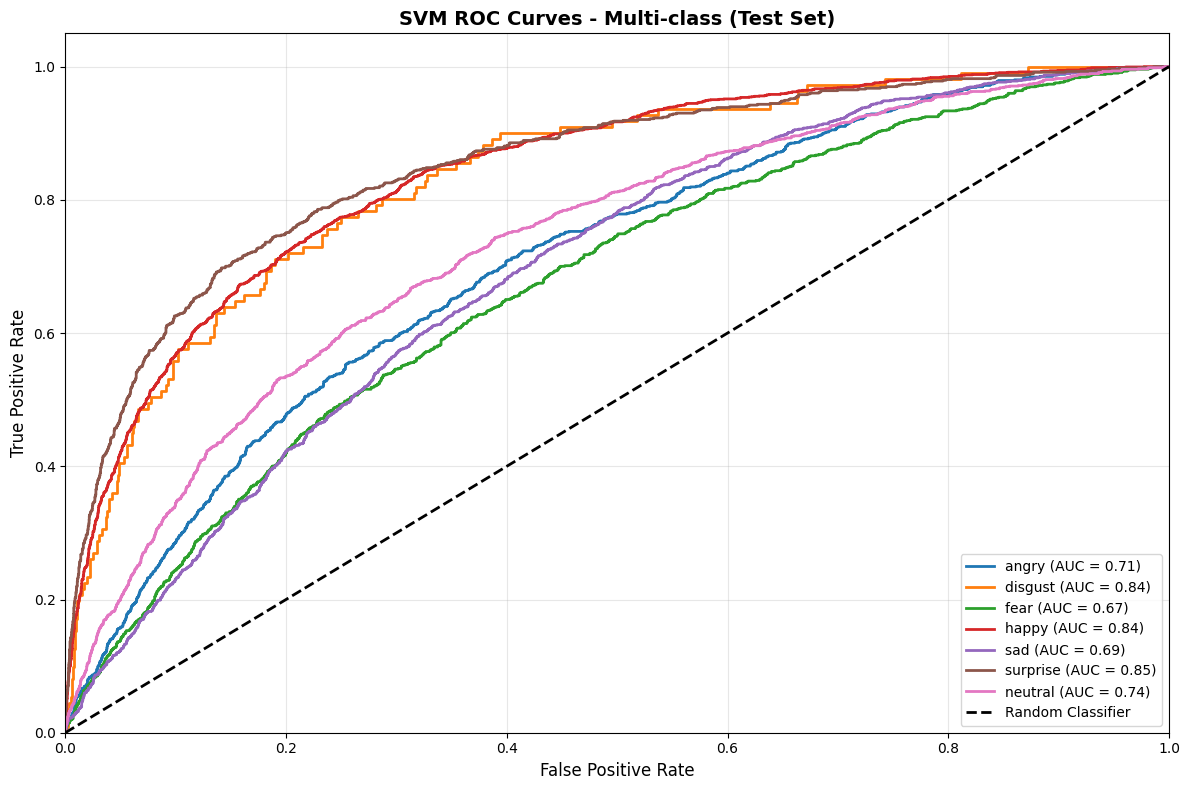


 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.284091 0.365344  0.319635      958
 disgust   0.157895 0.216216  0.182510      111
    fear   0.286749 0.270508  0.278392     1024
   happy   0.622076 0.584555  0.602732     1774
     sad   0.284507 0.242983  0.262111     1247
surprise   0.480412 0.560770  0.517490      831
 neutral   0.390764 0.356853  0.373039     1233

 Model saved: models/svm_best_20251123_140241.pkl
 Results saved: models/svm_results_20251123_140241.json

 SVM TRAINING PIPELINE COMPLETED SUCCESSFULLY

 Final Test Performance:
  ROC-AUC:  0.7629
  Accuracy: 0.4036
  F1-Score: 0.3623
 Model saved as: models/svm_best_20251123_140241.pkl


In [ ]:

print("\n" + "="*70)
print(" FINAL SVM EVALUATION ON TEST SET")
print("="*70)

# Preprocess test data (independent)
y_test_bin_svm = label_binarize(y_test, classes=range(n_classes_svm))

# Predict on test set
y_test_pred_svm = best_svm_model.predict(X_test_processed)
y_test_pred_proba_svm = best_svm_model.predict_proba(X_test_processed)

# Calculate all metrics
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_f1_macro_svm = f1_score(y_test, y_test_pred_svm, average='macro')
test_f1_weighted_svm = f1_score(y_test, y_test_pred_svm, average='weighted')
test_roc_auc_svm = roc_auc_score(y_test_bin_svm, y_test_pred_proba_svm, average='macro', multi_class='ovr')

print("\nTest Set Metrics:")
print(f"  ROC-AUC (macro):     {test_roc_auc_svm:.4f}")
print(f"  Accuracy:            {test_accuracy_svm:.4f}")
print(f"  F1-Score (macro):    {test_f1_macro_svm:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted_svm:.4f}")



# Classification report
print("\n Test Classification Report:")
report_test_svm = classification_report(y_test, y_test_pred_svm, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_test, y_test_pred_svm, target_names=emotion_labels, digits=4))



# Confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final SVM Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix
test_cm_path_svm = 'svm_test_confusion_matrix.png'
plt.savefig(test_cm_path_svm, dpi=300, bbox_inches='tight')

plt.show()

# ROC Curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes_svm):
    fpr, tpr, _ = roc_curve(y_test_bin_svm[:, i], y_test_pred_proba_svm[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
    


plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('SVM ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Log ROC curves
roc_path_svm = 'svm_test_roc_curves.png'
plt.savefig(roc_path_svm, dpi=300, bbox_inches='tight')

plt.show()

# Per-class metrics table
print("\n Per-Class Metrics:")
class_metrics_svm = []
for i, emotion in enumerate(emotion_labels):
    precision = cm_svm[i, i] / cm_svm[:, i].sum() if cm_svm[:, i].sum() > 0 else 0
    recall = cm_svm[i, i] / cm_svm[i, :].sum() if cm_svm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics_svm.append({
        'Emotion': emotion,
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'Support': int(cm_svm[i, :].sum())
    })

class_metrics_df_svm = pd.DataFrame(class_metrics_svm)
print(class_metrics_df_svm.to_string(index=False))

# Save and log class metrics
class_metrics_csv_svm = "svm_test_class_metrics.csv"
class_metrics_df_svm.to_csv(class_metrics_csv_svm, index=False)


# Save final model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename_svm = f'models/svm_best_{timestamp}.pkl'
joblib.dump(best_svm_model, model_filename_svm)
print(f"\n Model saved: {model_filename_svm}")




# Save complete results
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

final_results_svm = {
    'model_name': 'SVM',
    'timestamp': timestamp,
    'best_params': convert_to_native_types(best_params_svm),
    'best_run_id': best_run_id_svm,
    'validation_metrics': convert_to_native_types(best_metrics_svm),
    'test_metrics': {
        'roc_auc': float(test_roc_auc_svm),
        'accuracy': float(test_accuracy_svm),
        'f1_macro': float(test_f1_macro_svm),
        'f1_weighted': float(test_f1_weighted_svm)
    },
    'per_class_metrics': class_metrics_svm,
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'feature_dimension': int(X_train_processed.shape[1]),
    'emotion_labels': emotion_labels
}

results_filename_svm = f'models/svm_results_{timestamp}.json'
with open(results_filename_svm, 'w') as f:
    json.dump(final_results_svm, f, indent=4)
print(f" Results saved: {results_filename_svm}")



print("\n" + "="*70)
print(" SVM TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print("\n Final Test Performance:")
print(f"  ROC-AUC:  {test_roc_auc_svm:.4f}")
print(f"  Accuracy: {test_accuracy_svm:.4f}")
print(f"  F1-Score: {test_f1_macro_svm:.4f}")

print(f" Model saved as: {model_filename_svm}")
